In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import uncertainties.unumpy as unp
from uncertainties.umath import erfc as uerfc
from uncertainties.core import Variable
import uncertainties as u
import matplotlib as mpl
import os
from scipy.special import erfc
from lmfit import Model, fit_report
from datetime import datetime
from uncertainties import ufloat
from matplotlib import font_manager
from scipy.stats import chi2
from scipy.optimize import curve_fit
from IPython.display import Markdown
from io import StringIO

# Math Functions

In [2]:
def rect(x, b0, b1, mean):
    '''
    Descripción
    -----------
    Cálculo de una función lineal a partir de unos parámetros dados.
    
    Parámetros
    ----------
    x (float or np.array): Variable dependiente
    b0 (float): Corte con el eje y
    b1 (float): Pendiente
    mean (float): Centroide

    Retorna
    -------
    Arreglo (o valor individual) de la función evaluada en x
    '''
    return b0 + b1*(mean-x) #Background

##############################################################################

#Función Error Complemento
def rerfc(x, b0, b1, mean, stdev):
    '''
    Descripción
    -----------
    Función que calcula el fondo de un ajuste gaussiano describiendo la función error
    complemento adaptada a los parámetros de la gaussiana. Compatible con valores de
    incertidumbre (ufloat).
    
    Parámetros
    ----------
    x (1D np.array o ufloat): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float o ufloat): Cota inferior de la imagen de la función
    b1 (float o ufloat): Cota superior de la imagen de la función
    mean (float o ufloat): Centroide de la gaussiana y de la función
    stdev (float o ufloat): Desviación estándar de la gaussiana y se relaciona a la 
                           forma en la que decae la función.
    
    Retorna
    -------
    Los valores de la función error complemento adaptada a la gaussiana del ajuste.
    '''
    # Verificar si alguno de los parámetros es tipo ufloat
    if (isinstance(b0, Variable) or 
        isinstance(b1, Variable) or 
        isinstance(mean, Variable) or 
        isinstance(stdev, Variable)):
        
        # Si x es un array y hay parámetros ufloat, aplicamos operaciones elemento por elemento
        if isinstance(x, np.ndarray) and x.size > 1:
            result = np.zeros_like(x, dtype=object)
            for i, xi in enumerate(x):
                arg = (xi - mean) / (np.sqrt(2) * stdev)
                result[i] = b0 + (b1/2) * uerfc(arg)
            return result
        else:
            # Si x es un escalar o un array de un solo elemento
            return b0 + (b1/2) * uerfc((x - mean) / (np.sqrt(2) * stdev))
    else:
        # Si todos son números normales, usamos la versión de numpy
        return b0 + (b1/2) * erfc((x - mean) / (np.sqrt(2) * stdev))
##############################################################################

#Función Gaussiana con Fondo Lineal
def gaussian_rect(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, mean) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc(x, b0, b1, M, mean, stdev):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, mean, stdev) + M*np.exp(-(((mean-x)/stdev)**2)/2)

##############################################################################

#Error by Poisson's Distribution
def Poisson_Incertidumbre(y_values):
    '''
    Descripción
    -----------
    Se calcula la incertidumbre de los valores de las cuentas/canal de un espectro a
    partir del error de acuerdo a la distribución de Poisson.

    Parámetros
    ----------
    y_values (np.array): Valores de cuentas/canal en un espectro.

    Retorna:
    --------
    sigma_y (np.array): Valores de la incertidumbre asignada a los valores de las 
                        cuentas/canal de un espectro
    '''
    sigma_y = np.sqrt(np.abs(y_values))
    for i in range(len(y_values)):
        if y_values[i] == 0:
            sigma_y[i] = 1
    return sigma_y
#Función de 2 Gaussianas con Fondo Lineal
def gaussian_rect_2(x, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Corte con el eje y
    b1 (float): Pendiente de la recta
    M (float): Amplitud de la gaussiana
    mean (float): Centroide del pico
    stdev (float): Desviación estándar

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo modelado como una recta,
    correspondientes a los valores de x dados.
    
    '''
    return rect(x, b0, b1, (mean1+mean2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)

##############################################################################

#Función Gaussiana con fondo de la función error complemento
def gaussian_erfc_2(x, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2):
    '''
    Descripción
    -----------
    Función gaussiana sumada con la función error complemento.
    
    Parámetros
    ----------
    x (1D np.array): Arreglo con los datos en el eje x, en este caso, canales.
    b0 (float): Cota inferior de la imagen de la función 
    b1 (float): Cota superior de la imagen de la función
    M (float): Amplitud de la gaussiana
    mean (float): Centroide de la gaussiana y de la función
    stdev (float): Desviación estándar de la gaussiana y se relaciona a la forma
                    en la que decae la función.

    Retorna
    -------
    Valores de la función gaussiana sobre el fondo de la función error complemento
    correspondientes a los valores de x dados.
    '''
    return rerfc(x, b0, b1, (mean1+mean2)/2, (stdev1+stdev2)/2) + M1*np.exp(-(((mean1-x)/stdev1)**2)/2) + M2*np.exp(-(((mean2-x)/stdev2)**2)/2)


# Formato grafico

In [3]:
#%% FORMATO GRAFICAS
def formato_grafico(ax=None, decimalx=None, decimaly=None, legend_loc='upper right'):
    if ax is None:
        ax = plt.gca()

    fuente = 'sans'
    ax.title.set_size(14)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_family(fuente)
    ax.yaxis.label.set_family(fuente)
    ax.xaxis.label.set_family(fuente)
    ax.tick_params(axis='both', labelsize=14)

    plt.rcParams['mathtext.fontset'] = 'cm'  
    plt.rcParams['mathtext.rm'] = 'sans'  
    plt.rcParams['mathtext.default'] = 'rm'

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=True)
    ax.tick_params(axis='y', direction='in', which='both', left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in', bottom=True, top=True)
    ax.tick_params(axis='y', which='minor', direction='in', left=True, right=True)

    # Configurar la notación científica
    if decimalx is not None:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimalx}f}' if x != 0 else '0'))

    if decimaly is not None:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.{decimaly}f}' if x != 0 else '0'))

    if ax.get_legend() is not None:
        ax.legend(fontsize=16)

    font = font_manager.FontProperties(family='sans', style='normal', size=16)

    handles, labels = ax.get_legend_handles_labels()
    if handles and labels:
        ax.legend(loc=legend_loc, handles=handles, labels=labels, edgecolor='1', framealpha=0.5, prop=font)


In [4]:
def graficar_espectros(canales, espectro, fondo, corregido,
                       color='blue', titulo='Espectro', 
                       ST=None, save_path="espectro", 
                       unidades_x=r'$E_\gamma$ (canal)', 
                       unidades_y=r'$I_\gamma$ (cuentas/canal)'):
    """
    Genera dos gráficos: uno con el espectro original + fondo, y otro con el espectro corregido.

    Parámetros:
    - canales: array de canales
    - espectro: array con valores nominales del espectro crudo (puede venir de unumpy.nominal_values)
    - fondo: array con valores nominales del fondo
    - corregido: array con el espectro corregido (espectro - fondo), valores nominales
    - color: color para el espectro
    - titulo: título general del espectro (como el isótopo)
    - ST: tupla (Tp, FTW) para el título del gráfico, en µs
    - save_path: prefijo para guardar los .pdf
    - unidades_x: etiqueta del eje x
    - unidades_y: etiqueta del eje y
    """

    # Gráfico: Espectro con Fondo
    plt.figure(figsize=(16, 9))
    plt.plot(canales, fondo, ds='steps-mid', c='black', label='Fondo')
    plt.plot(canales, espectro, ds='steps-mid', c=color, label=titulo)
    plt.grid()
    plt.xlabel(unidades_x)
    plt.ylabel(unidades_y)
    if ST:
        plt.legend(title=fr'$T_p={ST[0]:.3f} \ \mu$s, $FTW={ST[1]:.3f} \ \mu$s')
    else:
        plt.legend()
    plt.savefig(f"{save_path}_con_fondo.pdf", format='pdf')
    plt.show()

    # Gráfico: Espectro sin Fondo
    plt.figure(figsize=(16, 9))
    plt.plot(canales, corregido, ds='steps-mid', c=color, label=titulo)
    plt.grid()
    plt.xlabel(unidades_x)
    plt.ylabel(unidades_y)
    if ST:
        plt.legend(title=fr'$T_p={ST[0]:.3f} \ \mu$s, $FTW={ST[1]:.3f} \ \mu$s')
    else:
        plt.legend()
    plt.savefig(f"{save_path}_sin_fondo.pdf", format='pdf')
    plt.show()


# Fit functions

## Curvefit

In [5]:
def gauss_ajuste_general(method, x, y_with_unc):
    """
    Función general para ajustar cualquiera de los cuatro modelos.
    
    Parameters:
    -----------
    method : int
        Método a utilizar (1, 2, 3 o 4)
    x : array
        Array con canales o energías
    y_with_unc : array
        Array con cuentas con incertidumbre
    
    Returns:
    --------
    popt : array
        Parámetros optimizados
    pcov : array
        Matriz de covarianza
    """
    # Extraer valores nominales y errores
    y_nom = unp.nominal_values(y_with_unc)
    y_err = unp.std_devs(y_with_unc)
    
    # Calcular estimaciones iniciales
    idx_max = np.argmax(y_nom)
    max_val = y_nom[idx_max]
    media = x[idx_max]
    sigma = np.sqrt(np.sum(y_nom * (x - media) ** 2) / np.sum(y_nom))
    min_val = np.min(y_nom)
    
    # Seleccionar función y valores iniciales según el método
    if method == 1:
        f = gaussian_rect
        p0 = [1, 1, max_val, media, sigma]
    elif method == 2:
        f = gaussian_erfc
        p0 = [1, 1, max_val, media, sigma]
    elif method == 3:
        # Para doble pico, intentar encontrar dos máximos
        # Dividir los datos en dos mitades
        mid_point = len(x) // 2
        idx_max1 = np.argmax(y_nom[:mid_point])
        idx_max2 = np.argmax(y_nom[mid_point:]) + mid_point
        
        # Si los índices están muy cercanos, separar artificialmente
        if abs(idx_max2 - idx_max1) < 5:
            media1 = media - sigma
            media2 = media + sigma
            max_val1 = max_val * 0.6
            max_val2 = max_val * 0.6
        else:
            media1 = x[idx_max1]
            media2 = x[idx_max2]
            max_val1 = y_nom[idx_max1] - min_val
            max_val2 = y_nom[idx_max2] - min_val
        
        f = gaussian_rect_2
        p0 = [min_val, 0.1, max_val1, max_val2, media1, media2, sigma, sigma]
    elif method == 4:
        # Mismo enfoque que el método 3
        mid_point = len(x) // 2
        idx_max1 = np.argmax(y_nom[:mid_point])
        idx_max2 = np.argmax(y_nom[mid_point:]) + mid_point
        
        if abs(idx_max2 - idx_max1) < 5:
            media1 = media - sigma
            media2 = media + sigma
            max_val1 = max_val * 0.6
            max_val2 = max_val * 0.6
        else:
            media1 = x[idx_max1]
            media2 = x[idx_max2]
            max_val1 = y_nom[idx_max1] - min_val
            max_val2 = y_nom[idx_max2] - min_val
        
        f = gaussian_erfc_2
        p0 = [1, 1, max_val1, max_val2, media1, media2, sigma, sigma]
    else:
        raise ValueError("El método debe ser 1, 2, 3 o 4")
    
    # Ajuste con curve_fit
    #try:
    popt, pcov = curve_fit(f, x, y_nom, p0=p0, sigma=y_err)
    return popt, pcov
    #except RuntimeError as e:
        #print(f"Error en el ajuste: {e}")
        # Intentar con otros valores iniciales o un método más robusto
        #try:
            #popt, pcov = curve_fit(f, x, y_nom, p0=p0, sigma=y_err, 
                                  #absolute_sigma=True, method='trf', max_nfev=10000)
            #return popt, pcov
        #except Exception as e2:
           # print(f"Error persistente en el ajuste: {e2}")
            # Devolver valores iniciales como mejor aproximación
           # pcov = np.zeros((len(p0), len(p0)))
            #np.fill_diagonal(pcov, 1.0)  # Incertidumbres unitarias
            #return p0, pcov


def Ajuste_gaussiano_iterativo(canal, cuentas, extremo_inferior, extremo_superior, method,
                              weight = 3.7, a_0=0, a_1=1, unidades='canal', titulo='Ajuste Gaussiano', 
                              ylim=None, save_path="Informe2/Imagenes", show_iterations=True):
    """
    Realiza un ajuste gaussiano iterativo: primero con rangos iniciales y luego refinado
    con rangos determinados automáticamente a partir del primer ajuste.
    
    Parameters:
    -----------
    canal : array
        Array con los canales o energías
    cuentas : array
        Array con las cuentas con incertidumbre
    extremo_inferior : int
        Índice inferior del rango inicial a ajustar
    extremo_superior : int
        Índice superior del rango inicial a ajustar
    method : int
        Método a utilizar (1, 2, 3 o 4)
    weight : float
        Factor para determinar el nuevo rango como [μ - weight*σ, μ + weight*σ]
    a_0, a_1 : float
        Parámetros de conversión de canal a energía (opcional)
    unidades : str
        Unidades en el eje x ('canal' o 'keV')
    titulo : str
        Título del ajuste
    ylim : tuple
        Límites para el eje y (opcional)
    save_path : str
        Ruta para guardar la imagen
    show_iterations : bool
        Si es True, muestra resultados del ajuste inicial y final
    """
    # Convertir todo el rango de canal a energía si es necesario
    full_x = canal * a_1 + a_0
    
    # ---- PRIMERA ITERACIÓN: AJUSTE INICIAL ----
    #print("\n===== AJUSTE INICIAL =====")
    
    # Extraer datos en el rango inicial especificado por el usuario
    x_inicial = full_x[extremo_inferior:extremo_superior]
    y_with_unc_inicial = cuentas[extremo_inferior:extremo_superior]
    
    # Realizar el ajuste inicial
    y_nom = unp.nominal_values(cuentas)
    y_errl = unp.std_devs(cuentas)
    y_nom_inicial = y_nom[extremo_inferior:extremo_superior] 
    y_err_inicial = y_errl[extremo_inferior:extremo_superior]

    # Ajuste utilizando la función general
    popt_inicial, pcov_inicial = gauss_ajuste_general(method, x_inicial, y_with_unc_inicial)
    
    # Procesar y mostrar resultados del ajuste inicial
    #procesar_y_mostrar_resultados(method, popt_inicial, pcov_inicial, x_inicial, y_with_unc_inicial, titulo, 
                               #unidades, a_0, a_1, ylim, save_path if show_iterations else None)
    
    # ---- DETERMINAR NUEVOS RANGOS BASADOS EN EL AJUSTE INICIAL ----
    
    # Calcular nuevos rangos según el método
    if method == 1 or method == 2:  # Ajuste de un solo pico
        mu = popt_inicial[3]  # posición del pico
        sigma = abs(popt_inicial[4])  # ancho del pico
        
        # Nuevo rango en unidades convertidas
        nuevo_min = int(mu - (weight * sigma))
        nuevo_max = int(mu + (weight * sigma))
        
    else:  # Ajuste de doble pico (métodos 3 y 4)
        mean1 = popt_inicial[4]  # posición del primer pico
        mean2 = popt_inicial[5]  # posición del segundo pico
        stdev1 = abs(popt_inicial[6])  # ancho del primer pico
        stdev2 = abs(popt_inicial[7])  # ancho del segundo pico
        
        # Tomar el rango que cubra ambos picos
        nuevo_min = min(mean1 - weight * stdev1, mean2 - weight * stdev2)
        nuevo_max = max(mean1 + weight * stdev1, mean2 + weight * stdev2)
    
    # Convertir de unidades de energía a índices de canal
    if a_1 != 0:
        # Convertir de energía a canal
        nuevo_min_canal = (nuevo_min - a_0) / a_1
        nuevo_max_canal = (nuevo_max - a_0) / a_1
    
    
    # ---- SEGUNDA ITERACIÓN: AJUSTE REFINADO ----
    #print("\n===== AJUSTE REFINADO =====")
    #print(f"Nuevo rango: [{nuevo_min:.2f}, {nuevo_max:.2f}] en unidades convertidas")
    #print(f"Nuevos índices: [{nuevo_min}, {nuevo_max}]")
    
    # Extraer datos en el nuevo rango
    x_refinado = full_x[nuevo_min:nuevo_max]
    if len(x_refinado) < len(popt_inicial):
        raise ValueError(f"No hay suficientes puntos de datos ({len(x_refinado)}) para ajustar {len(popt_inicial)} parámetros. Ajuste cancelado.")
    y_with_unc_refinado = cuentas[nuevo_min:nuevo_max]
    
    # Realizar el ajuste refinado
    popt_refinado, pcov_refinado = gauss_ajuste_general(method, x_refinado, y_with_unc_refinado)
    
    # Procesar y mostrar resultados del ajuste refinado
    titulo_refinado = f"{titulo} (Refinado)"
    #procesar_y_mostrar_resultados(method, popt_refinado, pcov_refinado, x_refinado, y_with_unc_refinado, 
                               #titulo_refinado, unidades, a_0, a_1, ylim, save_path)
    
    return popt_refinado, pcov_refinado, popt_inicial, pcov_inicial, x_inicial, y_with_unc_inicial , x_refinado, y_with_unc_refinado

def procesar_y_mostrar_resultados(method, popt, pcov, x, y_with_unc, titulo, 
                               unidades = 'canales', a_0= 0, a_1 = 1, ylim = None, save_path=None):
    """
    Procesa los resultados del ajuste y los muestra.
    """
    # Extraer valores nominales para la gráfica
    y_nom = unp.nominal_values(y_with_unc)
    y_std = unp.std_devs(y_with_unc)
    
    # Calcular el eje x para la representación
    x_ajuste = np.linspace(np.min(x), np.max(x), 500)
    
    # Calcular estadísticas para el ajuste
    if method == 1:
        y_fit = gaussian_rect(x, popt[0], popt[1], popt[2], popt[3], popt[4])
    elif method == 2:
        y_fit = gaussian_erfc(x, popt[0], popt[1], popt[2], popt[3], popt[4])
    elif method == 3:
        y_fit = gaussian_rect_2(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7])
    elif method == 4:
        y_fit = gaussian_erfc_2(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7])
    
    # Calcular residuos y estadísticas
    residuos = y_nom - y_fit
    
    # Grados de libertad (número de puntos - número de parámetros)
    if method in [1, 2]:
        num_params = 5  # Para modelos de pico simple
    else:
        num_params = 8  # Para modelos de doble pico
    
    nu = len(x) - num_params
    
    # Cálculo de Chi2
    chi2 = np.sum((residuos / y_std)**2)
    
    # Chi2 reducido
    red_chi2 = chi2 / nu
    
    # Cálculo de Q (p-value)
    from scipy import stats
    Q = 1 - stats.chi2.cdf(chi2, nu)
    
    # Cálculo de skewness y kurtosis de los residuos normalizados
    residuos_norm = residuos / y_std
    skewness = stats.skew(residuos_norm)
    kurtosis = stats.kurtosis(residuos_norm, fisher=False)  # Fisher=False para usar la definición estándar (normal = 3)
    wrapped_sum = u.wrap(np.sum)
    # Determinar tipo de modelo y calcular valores ajustados
    if method == 1:  # Gaussiana simple con fondo rectangular
        # Convertir parámetros a ufloat para propagar incertidumbres automáticamente
        uncertainties = np.sqrt(np.diag(pcov))
        b0 = ufloat(popt[0], uncertainties[0])
        b1 = ufloat(popt[1], uncertainties[1])
        M = ufloat(popt[2], uncertainties[2])
        mu = ufloat(popt[3], uncertainties[3])
        sigma = ufloat(abs(popt[4]), uncertainties[4])
        
        # Cálculo de parámetros derivados con propagación automática
        FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
        delta_E = x[1]-x[0]
        bg = rect(x,b0,b1,mu)
        I = y_with_unc - bg
        Intensidad = wrapped_sum(I*delta_E)
        Integral = abs((2 * np.pi) ** 0.5 * M * sigma)
        
        # Valores para graficar (solo valores nominales)
        y_ajuste = gaussian_rect(x_ajuste, popt[0], popt[1], popt[2], popt[3], popt[4])
        recta_ajuste = rect(x_ajuste, popt[0], popt[1], popt[3])
                # ----- GRAFICAR -----
        plt.figure(figsize=(16, 9))
        plt.step(x, y_nom, 'k', label=titulo, where='mid')
        label_gauss = r'$b_0 + b_1 (x - \mu) + M \exp \left[-\frac{(x-\mu)^2}{2\sigma^2} \right]$'
        label_recta = r'$b_0 + b_1 (x - \mu)$'
        plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2, label=label_gauss)
        plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=label_recta)
    
        plt.grid()
        plt.title(titulo)
        plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
        plt.legend(loc='best')
    
        if unidades == 'canal':
            plt.xlabel(r'canal')
        elif unidades == 'keV':
            plt.xlabel(r'$E_{\gamma}$' + ' (keV)')
    
        if ylim:
            plt.ylim(ylim)
        formato_grafico()
        plt.tight_layout()
        plt.show()
        if save_path is not None:
            filename = f"Practica2_{titulo.replace(' ', '_')}.png"
            full_path = os.path.join(save_path, filename)
            plt.savefig(full_path, dpi=300, bbox_inches='tight')
            # Imprimir resultados con estadísticas
        markdown_text= print_single_peak_results_unc(titulo, b0, b1, M, mu, sigma, FWHM, Integral, Intensidad, 
                                     nu=nu, chi2=chi2, red_chi2=red_chi2, 
                                     Q=Q, skewness=skewness, kurtosis=kurtosis)
        
    elif method == 2:  # Gaussiana simple con fondo erfc
        # Convertir parámetros a ufloat para propagar incertidumbres automáticamente
        uncertainties = np.sqrt(np.diag(pcov))
        b0 = ufloat(popt[0], uncertainties[0])
        b1 = ufloat(popt[1], uncertainties[1])
        M = ufloat(popt[2], uncertainties[2])
        mu = ufloat(popt[3], uncertainties[3])
        sigma = ufloat(abs(popt[4]), uncertainties[4])
        
         # Cálculo de parámetros derivados con propagación automática
        FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
        bg = rerfc(x,b0,b1,mu,sigma)
        I = y_with_unc - bg
        delta_E = x[1]-x[0]
        Intensidad = wrapped_sum(I*delta_E)
        Integral = abs((2 * np.pi) ** 0.5 * M * sigma)
        
        # Valores para graficar (solo valores nominales)
        y_ajuste = gaussian_erfc(x_ajuste, popt[0], popt[1], popt[2], popt[3], popt[4])
        recta_ajuste = rerfc(x_ajuste, popt[0], popt[1], popt[3], popt[4])
         # ----- GRAFICAR -----
        plt.figure(figsize=(19, 9))
        plt.step(x, y_nom, 'k', label=titulo, where='mid')
        label_gauss = r'$b_0 + \frac{b_1}{2} \operatorname{erfc} \left( \frac{x - \mu}{\sqrt{2} \sigma} \right) + M \exp \left[-\frac{(x-\mu)^2}{2\sigma^2} \right]$'
        label_recta = r'$b_0 + \frac{b_1}{2} \operatorname{erfc} \left( \frac{x - \mu}{\sqrt{2} \sigma} \right)$'
        plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2, label=label_gauss)
        plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=label_recta)
    
        plt.grid()
        plt.title(titulo)
        plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
        plt.legend(loc='best')
    
        if unidades == 'canal':
            plt.xlabel(r'canal')
        elif unidades == 'keV':
            plt.xlabel(r'$E_{\gamma}$' + ' (keV)')
    
        if ylim:
            plt.ylim(ylim)
            
        plt.tight_layout()
        formato_grafico()
        plt.show()
        if save_path is not None:
            filename = f"Practica2_{titulo.replace(' ', '_')}.png"
            full_path = os.path.join(save_path, filename)
            plt.savefig(full_path, dpi=300, bbox_inches='tight')
        # Imprimir resultados con estadísticas
        markdown_text=print_single_peak_results_unc(titulo, b0, b1, M, mu, sigma, FWHM, Intensidad,Integral,
                                     nu=nu, chi2=chi2, red_chi2=red_chi2, 
                                     Q=Q, skewness=skewness, kurtosis=kurtosis)
        
    elif method == 3:  # Doble gaussiana con fondo rectangular
        # Convertir parámetros a ufloat para propagar incertidumbres automáticamente
        uncertainties = np.sqrt(np.diag(pcov))
        b0 = ufloat(popt[0], uncertainties[0])
        b1 = ufloat(popt[1], uncertainties[1])
        M1 = ufloat(popt[2], uncertainties[2])
        M2 = ufloat(popt[3], uncertainties[3])
        mean1 = ufloat(popt[4], uncertainties[4])
        mean2 = ufloat(popt[5], uncertainties[5])
        stdev1 = ufloat(abs(popt[6]), uncertainties[6])
        stdev2 = ufloat(abs(popt[7]), uncertainties[7])
        
        # Cálculo de parámetros derivados con propagación automática
        FWHM1 = 2 * np.sqrt(2 * np.log(2)) * stdev1
        FWHM2 = 2 * np.sqrt(2 * np.log(2)) * stdev2
        I1 = abs((2 * np.pi) ** 0.5 * M1 * stdev1)
        I2 = abs((2 * np.pi) ** 0.5 * M2 * stdev2)
        
        # Valores para graficar (solo valores nominales)
        y_ajuste = gaussian_rect_2(x_ajuste, popt[0], popt[1], popt[2], popt[3], 
                                 popt[4], popt[5], popt[6], popt[7])
        recta_ajuste = popt[0] + popt[1] * (0.5*(popt[4] + popt[5]) - x_ajuste)
         # ----- GRAFICAR -----
        plt.figure(figsize=(10, 5))
        plt.step(x, y_nom, 'k', label=titulo, where='mid')
        label_gauss = r'$b_0 + b_1 (x - \mu) + M_1 \exp \left[-\frac{(x-\mu_1)^2}{2\sigma_1^2} \right] + M_2 \exp \left[-\frac{(x-\mu_2)^2}{2\sigma_2^2} \right]$'
        label_recta = r'$b_0 + b_1 (x - \mu)$'
        plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2, label=label_gauss)
        plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=label_recta)
    
        plt.grid()
        plt.title(titulo)
        plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
        plt.legend(loc='best')
    
        if unidades == 'canal':
            plt.xlabel(r'canal')
        elif unidades == 'keV':
            plt.xlabel(r'$E_{\gamma}$' + ' (keV)')
    
        if ylim:
            plt.ylim(ylim)
    
        plt.tight_layout()
        plt.show()
        if save_path is not None:
            filename = f"Practica2_{titulo.replace(' ', '_')}.png"
            full_path = os.path.join(save_path, filename)
            plt.savefig(full_path, dpi=300, bbox_inches='tight')
        # Imprimir resultados con estadísticas
        markdown_text= print_double_peak_results_unc(titulo, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2, 
                                     FWHM1, FWHM2, I1, I2, 
                                     nu=nu, chi2=chi2, red_chi2=red_chi2, 
                                     Q=Q, skewness=skewness, kurtosis=kurtosis)
        
    elif method == 4:  # Doble gaussiana con fondo erfc
        # Convertir parámetros a ufloat para propagar incertidumbres automáticamente
        uncertainties = np.sqrt(np.diag(pcov))
        b0 = ufloat(popt[0], uncertainties[0])
        b1 = ufloat(popt[1], uncertainties[1])
        M1 = ufloat(popt[2], uncertainties[2])
        M2 = ufloat(popt[3], uncertainties[3])
        mean1 = ufloat(popt[4], uncertainties[4])
        mean2 = ufloat(popt[5], uncertainties[5])
        stdev1 = ufloat(abs(popt[6]), uncertainties[6])
        stdev2 = ufloat(abs(popt[7]), uncertainties[7])
        
        # Cálculo de parámetros derivados con propagación automática
        FWHM1 = 2 * np.sqrt(2 * np.log(2)) * stdev1
        FWHM2 = 2 * np.sqrt(2 * np.log(2)) * stdev2
        I1 = abs((2 * np.pi) ** 0.5 * M1 * stdev1)
        I2 = abs((2 * np.pi) ** 0.5 * M2 * stdev2)
        
        # Valores para graficar (solo valores nominales)
        y_ajuste = gaussian_erfc_2(x_ajuste, popt[0], popt[1], popt[2], popt[3], 
                                 popt[4], popt[5], popt[6], popt[7])
        recta_ajuste = popt[0] + (popt[1] * 0.5) * (
            erfc((x_ajuste - popt[4]) / (np.sqrt(2) * popt[6])) + 
            erfc((x_ajuste - popt[5]) / (np.sqrt(2) * popt[7]))
        )
         # ----- GRAFICAR -----
        plt.figure(figsize=(10, 5))
        plt.step(x, y_nom, 'k', label=titulo, where='mid')
        label_gauss = r'$b_0 + \frac{b_1}{2} \operatorname{erfc} \left( \frac{x - \mu}{\sqrt{2} \sigma} \right) + M_1 \exp \left[-\frac{(x-\mu_1)^2}{2\sigma_1^2} \right] + M_2 \exp \left[-\frac{(x-\mu_2)^2}{2\sigma_2^2} \right]$'
        label_recta = r'$b_0 + \frac{b_1}{2} \operatorname{erfc} \left( \frac{x - \mu}{\sqrt{2} \sigma} \right)$'
        plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2, label=label_gauss)
        plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=label_recta)
    
        plt.grid()
        plt.title(titulo)
        plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
        plt.legend(loc='best')
    
        if unidades == 'canal':
            plt.xlabel(r'canal')
        elif unidades == 'keV':
            plt.xlabel(r'$E_{\gamma}$' + ' (keV)')
    
        if ylim:
            plt.ylim(ylim)
    
        plt.tight_layout()
        plt.show()
        
        if save_path is not None:
            filename = f"Practica2_{titulo.replace(' ', '_')}.png"
            full_path = os.path.join(save_path, filename)
            plt.savefig(full_path, dpi=300, bbox_inches='tight')
        # Imprimir resultados con estadísticas
        print_double_peak_results_unc(titulo, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2, 
                                     FWHM1, FWHM2, I1, I2,
                                     nu=nu, chi2=chi2, red_chi2=red_chi2, 
                                     Q=Q, skewness=skewness, kurtosis=kurtosis)
    
    
    return Markdown(markdown_text)
    
   

def print_single_peak_results_unc(titulo, A, B, C, mu, sigma, FWHM, Integral,Intensidad, nu=None, chi2=None, 
                                 red_chi2=None, Q=None, skewness=None, kurtosis=None):
    """ Imprime los resultados para un ajuste de pico simple usando ufloat. """
    print("\nPico: ", titulo)
    print("b0: {}".format(A))
    print("b1: {}".format(B))
    print("M: {}".format(C))
    print("μ: {}".format(mu))
    print("σ: {}".format(sigma))
    print("FWHM: {}".format(FWHM))
    print("Intensidad: {}".format(Intensidad))
    print("Intefral: {}".format(Integral))
    
    # Parámetros estadísticos adicionales
    if nu is not None:
        print("nu: {}".format(nu))
    if chi2 is not None:
        print("Chi2: {}".format(chi2))
    if red_chi2 is not None:
        print("Reduced Chi2: {}".format(red_chi2))
    if Q is not None:
        print("Q: {}".format(Q))
    if skewness is not None:
        print("Skewness: {}".format(skewness))
    if kurtosis is not None:
        print("Kurtosis: {}".format(kurtosis))

def print_double_peak_results_unc(titulo, b0, b1, M1, M2, mean1, mean2, stdev1, stdev2, 
                                 FWHM1, FWHM2, I1, I2, nu=None, chi2=None, red_chi2=None, 
                                 Q=None, skewness=None, kurtosis=None):
    """ Imprime los resultados para un ajuste de doble pico usando ufloat. """
    print("\nPico: ", titulo)
    print("b0: {}".format(b0))
    print("b1: {}".format(b1))
    
    # Pico 1
    print("\n--- Pico 1 ---")
    print("M1: {}".format(M1))
    print("μ1: {}".format(mean1))
    print("σ1: {}".format(stdev1))
    print("FWHM1: {}".format(FWHM1))
    print("Intensidad1: {}".format(I1))
    
    # Pico 2
    print("\n--- Pico 2 ---")
    print("M2: {}".format(M2))
    print("μ2: {}".format(mean2))
    print("σ2: {}".format(stdev2))
    print("FWHM2: {}".format(FWHM2))
    print("Intensidad2: {}".format(I2))
    
    # Parámetros estadísticos adicionales
    print("\n--- Estadísticas del ajuste ---")
    if nu is not None:
        print("nu: {}".format(nu))
    if chi2 is not None:
        print("Chi2: {}".format(chi2))
    if red_chi2 is not None:
        print("Reduced Chi2: {}".format(red_chi2))
    if Q is not None:
        print("Q: {}".format(Q))
    if skewness is not None:
        print("Skewness: {}".format(skewness))
    if kurtosis is not None:
        print("Kurtosis: {}".format(kurtosis))


## lmfit

In [6]:
def lmfit_custom_fit(x, y_with_unc, modelo, method, xmin, xmax):
    """
    Ajusta un modelo a datos con incertidumbre usando lmfit. Calcula τ y κ con propagación
    de incertidumbre y los incluye como parámetros fijos en el fit_report.

    Parameters:
    - x (np.array): canales
    - y_with_unc (np.array of ufloat): cuentas con incertidumbre
    - modelo (function): modelo a ajustar (sin τ ni κ como parámetros)
    - xmin, xmax (int): índice de rango de ajuste

    Returns:
    - result (lmfit.model.ModelResult): resultado del ajuste
    """

    # Separar nominales y desviaciones
    y_nom = unp.nominal_values(y_with_unc)
    y_err = unp.std_devs(y_with_unc)

    # Subconjunto del rango de ajuste
    x_fit = x[xmin:xmax]
    y_fit = y_nom[xmin:xmax]
    y_fit_err = y_err[xmin:xmax]

    # Determinar si es modelo de un pico o doble pico
    is_double_peak = (method == 3 or method == 4)

    # Crear model
    Rmodel = Model(modelo)
    params = Rmodel.make_params()
    
    # Estimaciones iniciales base
    idx_max = np.argmax(y_fit)
    peak_max = y_fit[idx_max]
    peak_pos = x_fit[idx_max]
    stdev_guess = (x_fit[-1] - x_fit[0]) / 6

    # Añadir parámetros básicos comunes
    params.add('b0', value=1, vary=True)
    params.add('b1', value=1, vary=True)

    if is_double_peak:
        # Buscar posibles dos picos
        # (Este es un enfoque simple, se puede mejorar)
        half_width = len(x_fit) // 3
        
        # Buscar el primer pico en la primera mitad del rango
        y_left = y_fit[:len(y_fit)//2]
        idx_max1 = np.argmax(y_left)
        peak_pos1 = x_fit[idx_max1]
        peak_max1 = y_fit[idx_max1]
        
        # Buscar el segundo pico en la segunda mitad del rango
        y_right = y_fit[len(y_fit)//2:]
        idx_max2 = np.argmax(y_right) + len(y_fit)//2
        peak_pos2 = x_fit[idx_max2]
        peak_max2 = y_fit[idx_max2]
        
        # Si los picos están muy cerca, intentar otra estrategia
        if abs(peak_pos2 - peak_pos1) < stdev_guess:
            # Usar el pico principal y estimar un segundo pico cercano
            peak_pos1 = peak_pos - stdev_guess
            peak_pos2 = peak_pos + stdev_guess
            peak_max1 = peak_max * 0.7
            peak_max2 = peak_max * 0.7
        
        # Añadir parámetros para modelo de doble pico
        params.add('M1', value=peak_max1, vary=True, min=0)
        params.add('M2', value=peak_max2, vary=True, min=0)
        params.add('mean1', value=peak_pos1, vary=True, min=0)
        params.add('mean2', value=peak_pos2, vary=True, min=0)
        params.add('stdev1', value=stdev_guess, vary=True, min=0)
        params.add('stdev2', value=stdev_guess, vary=True, min=0)
    else:
        # Añadir parámetros para modelo de un solo pico
        params.add('M', value=peak_max, vary=True, min=0)
        params.add('mean', value=peak_pos, vary=True, min=0)
        params.add('stdev', value=stdev_guess, vary=True, min=0)

    # Ajuste
    result = Rmodel.fit(y_fit, x=x_fit, params=params, weights=1/y_fit_err, nan_policy='omit')
    parametros = result.params

    return result, parametros

def plot_and_markdown_fit_report(result, x, y_with_unc, x_ajuste, y_ajuste, recta_ajuste, 
                                titulo="Ajuste", method = 1, unidades="canal", ylim=None,
                                save_path=None, show_plot=True):
    """
    Genera gráfica del ajuste + fit_report en formato Markdown extendido.
    Compatible con modelos de un pico y doble pico.

    Parameters:
    - result: objeto de resultado de lmfit
    - x, y: datos experimentales (sin incertidumbre)
    - x_ajuste: eje x del modelo ajustado
    - y_ajuste: modelo completo (recta + gauss)
    - recta_ajuste: modelo de fondo lineal
    - titulo: título del gráfico y nombre del archivo
    - unidades: 'canal' o 'keV'
    - ylim: límites opcionales para eje y
    - save_path: ruta donde guardar la imagen
    - show_plot: si se debe mostrar el gráfico en pantalla

    Returns:
    - Markdown fit report como objeto renderizable en Jupyter
    """
    y = unp.nominal_values(y_with_unc)
    # Determinar si es modelo de un pico o doble pico
    is_double_peak = 'mean1' in result.params and 'mean2' in result.params
    
    # ----- GRAFICAR -----
    plt.figure(figsize=(16, 9))
    plt.step(x, y, 'k', label='{}'.format(titulo), where='mid')
    
    # Etiqueta de la curva de ajuste según el tipo de modelo
    if is_double_peak:
        curve_label = r'Modelo de doble pico gaussiano'
    else:
        curve_label = r'Modelo de pico simple gaussiano'
        
    # Etiqueta de fondo según tipo de modelo
    if method % 2 == 0:
        bg_label = r'Fondo con función error'
        
    else:
        bg_label = r'Fondo lineal'
        
    plt.plot(x_ajuste, y_ajuste, '--r', linewidth=2, label=curve_label)
    plt.plot(x_ajuste, recta_ajuste, '--b', linewidth=2, label=bg_label)

    plt.grid()
    plt.title(titulo)
    plt.ylabel(r'$I_{\gamma}$' + ' [cuentas / canal]')
    plt.legend(loc='best')

    if unidades == 'canal':
        plt.xlabel(r'canal')
    elif unidades == 'keV':
        plt.xlabel(r'$E_{\gamma}$' + ' (keV)')

    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    formato_grafico()
    if save_path is not None:
        filename = f"Practica2_{titulo.replace(' ', '_')}.png"
        full_path = os.path.join(save_path, filename)
        plt.savefig(full_path, dpi=300, bbox_inches='tight')

    if show_plot:
        plt.show()
    
    # -------- CALCULAR TAU, KAPPA, FHWM e I --------
    # Solo para modelos de un pico
    if not is_double_peak:
        # Recuperar parámetros ajustados con incertidumbre
        b1 = ufloat(result.params['b0'].value, result.params['b0'].stderr)
        b0 = ufloat(result.params['b1'].value, result.params['b1'].stderr)
        mean = ufloat(result.params['mean'].value, result.params['mean'].stderr)
        stdev = ufloat(result.params['stdev'].value, result.params['stdev'].stderr)
        M = ufloat(result.params['M'].value, result.params['M'].stderr)
        # Diferencias para momentos centrales
        dif = x_ajuste - mean
        # Usar wrap para incertidumbre
        wrapped_mean = u.wrap(np.mean)
        wrapped_sum = u.wrap(np.sum)
        momento_3 = wrapped_mean((dif)**3)
        momento_4 = wrapped_mean((dif)**4)
        delta_E = x[1]-x[0]
        tau = momento_3 / (stdev**3)
        kappa = momento_4 / (stdev**4)
        FWHM = 2 * np.sqrt(2 * np.log(2)) * stdev
        if method % 2 == 0:
             bg = rerfc(x,b0,b1,mean,stdev)

        else:
             bg = rect(x,b0,b1,mean)
            
        I = y_with_unc - bg
        Intensidad = wrapped_sum(I*delta_E)
        Integral = abs((2 * np.pi) ** 0.5 * M * stdev)
    
    # ----- CALCULAR Q -----
    Chi2 = result.chisqr
    df = result.ndata - result.nvarys
    Q = chi2.sf(Chi2, df).astype(np.float64)
    
    # ----- FIT REPORT -----
    report = fit_report(result, show_correl=False, min_correl=0.1).split('\n')
    
    extended_report = []
    for line in report:
        extended_report.append(line)
        if 'R-squared' in line:
            extended_report.append(f'     Q  = {Q:.8f}')
            extended_report.append(f'     df = {df}')
        
        # Añadir tau y kappa solo para modelos de un pico
        if not is_double_peak and 'stdev' in line:
            extended_report.append(f'    Tau:    {tau:.8f}')
            extended_report.append(f'    Kappa:  {kappa:.8f}')
            extended_report.append(f'    FWHM:    {FWHM:.8f}')
            extended_report.append(f'    Intensidad:  {Intensidad:.8f}')
            extended_report.append(f'    Integral:  {Integral:.8f}')
    
    markdown_text = '```text\n' + '\n'.join(extended_report) + '\n```'
    return Markdown(markdown_text)

## ODR

# Main function

## Curvefit


In [7]:
def analizar_espectro(archivo_datos, archivo_fondo, configuracion_picos, 
                     calibracion=None, save_path=None, ylim = None):
    """
    Realiza un análisis completo de un espectro, incluyendo ajuste de picos y generación de gráficas.
    
    Parámetros:
    -----------
    archivo_datos : str
        Ruta al archivo que contiene los datos del espectro.
    archivo_fondo : str, opcional
        Ruta al archivo de fondo. Si es None, no se resta el fondo.
    configuracion_picos : list, opcional
        Lista de diccionarios que contiene la configuración para cada pico a analizar.
        Cada diccionario debe tener: min_range, max_range, method, title.
    calibracion : tuple, opcional
        Parámetros de calibración (a_0, a_1) para convertir canales a energía.
    save_path : str, opcional
        Ruta donde se guardarán las gráficas. Si es None, no se generan gráficas.
    """
    # 1. Cargar los datos con incertidumbres
    canales, cuentas_con_inc = load_spectrum_with_uncertainty(archivo_datos)
    canales1, fondo_con_inc = load_spectrum_with_uncertainty(archivo_fondo)
    if len(cuentas_con_inc) != len(fondo_con_inc):
        raise ValueError("⚠️ Raw data and background must be the same length.")
    # 2. Cargar y restar el fondo si se proporciona
    #if archivo_fondo:
       # _, fondo_con_inc = load_spectrum_with_uncertainty(archivo_fondo)
      #  # Restar el fondo de las cuentas
    cuentas_netas_con_inc = cuentas_con_inc - fondo_con_inc
  #  else:
        #cuentas_netas_con_inc = cuentas_con_inc
    #

    # 3. Procesar cada pico según la configuración
    if configuracion_picos is None:
        configuracion_picos = []
 # Número de picos basado en la longitud de peak_configs
    num_peaks = len(configuracion_picos)

    # Lista para almacenar los resultados
    all_results = []

    print(f"\n🧾 Procesando {num_peaks} picos...")

    for i in range(num_peaks):
        print(f"\n--- Pico #{i+1} ---")
    
        # Obtener configuración del pico actual
        config = configuracion_picos[i]
        min_range = config["min_range"]
        max_range = config["max_range"]
        method = config["method"]
        titulo = config["title"]
        
        
        # Convertir a energía si se proporciona calibración
        unidades = 'canal'
        if calibracion:
            a_0, a_1 = calibracion
            x_pico_energia = a_0 + a_1 * x_pico
            x_pico = x_pico_energia
            unidades = 'keV'
        
        # Extraer valores nominales para el ajuste inicial
        #y_nom = unp.nominal_values(cuentas_netas_con_inc)
        
        # Definir las funciones de ajuste según el método
        # (Aquí se asume que ya tienes definidas las funciones gaussian_rect, gaussian_erfc, etc.)
        
        popt_refinado, pcov_refinado, popt_inicial, pcov_inicial, x_inicial, y_with_unc_inicial , x_refinado, y_with_unc_refinado = Ajuste_gaussiano_iterativo(canal = canales, cuentas = cuentas_con_inc, extremo_inferior = min_range, extremo_superior = max_range, method =method,
                              weight=3.0, a_0=0, a_1=1, unidades='canal', titulo='Ajuste Gaussiano',ylim=None, save_path="Imagenes/CurveFit", show_iterations=True)
        
        md1 = procesar_y_mostrar_resultados(method = method, popt = popt_inicial, pcov = pcov_inicial, x = x_inicial, y_with_unc = y_with_unc_inicial, titulo = titulo, 
                               unidades = 'Canales', a_0 = 0, a_1 = 1, ylim = None, save_path=None)
        display(md1)

        md2 =procesar_y_mostrar_resultados(method = method, popt = popt_refinado, pcov = pcov_refinado, x =  x_refinado, y_with_unc = y_with_unc_refinado, titulo = titulo, 
                               unidades = 'Canales', a_0 = 0, a_1 = 1, ylim = None, save_path = None)
        display(md2)
    return popt_refinado, pcov_refinado, popt_inicial, pcov_inicial

## lmfit



In [8]:

def load_spectrum_with_uncertainty(file_path):
    """
    Carga un archivo .mca ignorando encabezados y basura final.
    Lee solo datos entre <<DATA>> y <<END>> o hasta donde sean válidos.

    Returns:
    - channels: np.array de canales generados automáticamente
    - spectrum_with_unc: np.array de ufloat con cuentas e incertidumbre de Poisson
    """
  

    counts = []
    data_section = False

    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            line = line.strip()

            if '<<DATA>>' in line:
                data_section = True
                continue
            elif '<<END>>' in line:
                break

            if data_section:
                try:
                    value = float(line)
                    counts.append(value)
                except ValueError:
                    continue  # ignorar líneas basura

    counts = np.array(counts)
    channels = np.arange(len(counts))
    #channels = data[:, 0].flatten()
    uncertainties = Poisson_Incertidumbre(counts)
    spectrum_with_unc = unp.uarray(counts, uncertainties)

    return channels, spectrum_with_unc



def peak_fit(raw_data_path, background_path, 
             peak_configs, width=3.5,
             save_path="Imagenes/lmFit", unidades="canal", ylim=None):
    """
    Carga datos crudos y de fondo, aplica propagación de incertidumbre y 
    muestra un gráfico del espectro corregido. Luego analiza los picos
    en los rangos especificados con el método indicado para cada pico.

    Parameters:
    - raw_data_path (str): Ruta al archivo de datos crudos
    - background_path (str): Ruta al archivo de fondo
    - peak_configs (list): Lista de diccionarios con la configuración de cada pico.
                          Cada diccionario debe tener las claves:
                          - "min_range": Canal mínimo
                          - "max_range": Canal máximo
                          - "method": Método a usar (1, 2, 3 o 4)
                          Ejemplo: [{"min_range": 100, "max_range": 150, "method": 1}, ...]
    - width (float): Factor para calcular el ancho del segundo ajuste (default: 3.0)
    - save_path (str): Ruta opcional para guardar el gráfico
    - unidades (str): Unidades para el eje x (default: "canal")
    - ylim (tuple): Límites para el eje y (opcional)

    Returns:
    - all_results (list): Lista con los resultados de todos los segundos ajustes
    """

    print(f"\n➡️ Cargando datos con incertidumbre de Poisson...")
    channels_raw, raw_with_unc = load_spectrum_with_uncertainty(raw_data_path)
    channels_back, background_with_unc = load_spectrum_with_uncertainty(background_path)

    if len(raw_with_unc) != len(background_with_unc):
        raise ValueError("⚠️ Raw data and background must be the same length.")

    corrected_data = raw_with_unc - background_with_unc
    corrected_counts = unp.nominal_values(corrected_data)
    graficar_espectros(channels_raw,
                   unp.nominal_values(raw_with_unc),
                   unp.nominal_values(background_with_unc),
                   corrected_counts,
                   color='tab:blue',
                   titulo=r'$^{137}$Cs',
                   save_path=save_path)


    # Número de picos basado en la longitud de peak_configs
    num_peaks = len(peak_configs)

    # Lista para almacenar los resultados
    all_results = []

    print(f"\n🧾 Procesando {num_peaks} picos...")

    for i in range(num_peaks):
        print(f"\n--- Pico #{i+1} ---")
    
        # Obtener configuración del pico actual
        config = peak_configs[i]
        min_range = config["min_range"]
        max_range = config["max_range"]
        method = config["method"]
        title = config["title"]
    
        print(f"Usando rango: Canal mínimo = {min_range}, Canal máximo = {max_range}")
        print(f"Método seleccionado: {method}")
    
        try:
            # Seleccionar modelo según método especificado para este pico
            if method == 1:
                modelo = gaussian_rect
       
            elif method == 2:
                modelo = gaussian_erfc
  
            elif method == 3:
                modelo = gaussian_rect_2
       
            elif method == 4:
                modelo = gaussian_erfc_2
         
            else:
                raise ValueError(f"Método no válido para el pico #{i+1}. Usa 1, 2, 3 o 4.")
        
            # Convertir a índices de canal
            idx_min = int(np.searchsorted(channels_raw, min_range))
            idx_max = int(np.searchsorted(channels_raw, max_range))
        
            # Datos para ajuste
            x = channels_raw
            y_with_unc = corrected_data
        
            # Primer ajuste
            results, params = lmfit_custom_fit(x, y_with_unc, modelo, method, idx_min, idx_max)
            
            # Preparar datos para gráfica del primer ajuste
            x_data = x[idx_min:idx_max]
            y_nom = y_with_unc[idx_min:idx_max]
            #params = results.params
            x_ajuste = np.linspace(min_range, max_range, 500)
            
            # Calcular valores del modelo para la curva de ajuste
            if method == 1:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta = params['b0'].value + params['b1'].value * (params['mean'] - x_ajuste)
            elif method == 2:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta = params['b0'].value + (params['b1'].value/2)*erfc((x_ajuste - params['mean'])/(np.sqrt(2)*params['stdev']))
            elif method == 3:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta = params['b0'].value + params['b1'].value * (0.5*(params['mean1'] + params['mean2']) - x_ajuste)
            elif method == 4:
                y_ajuste = modelo(x_ajuste, **{k: params[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                # Promedio de dos funciones erfc para doble pico
                recta = params['b0'].value + (params['b1'].value) * 0.5 * (
                    erfc((x_ajuste - params['mean1'])/(np.sqrt(2)*params['stdev1'])) + 
                    erfc((x_ajuste - params['mean2'])/(np.sqrt(2)*params['stdev2']))
                )
            
            # Título automático para el primer ajuste
 
            
            # Graficar y mostrar Markdown report para el primer ajuste
            md = plot_and_markdown_fit_report(
                result=results,
                x=x_data,
                y_with_unc=y_nom,
                x_ajuste=x_ajuste,
                y_ajuste=y_ajuste,
                recta_ajuste=recta,
                titulo=title,
                method=method,
                unidades=unidades,
                ylim=ylim,
                save_path=save_path,
                show_plot=True
            )
            display(md)
            
            # Realizar segundo ajuste con nuevos rangos calculados
            # Para métodos de doble pico, usamos el promedio de medias y desviaciones
            if method in [1, 2]:
                parameters = [params[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']]
                mean = parameters[3]
                stdev = parameters[4]             
                x0_new = int(mean - width * stdev)
                x1_new = int(mean + width * stdev)
            else:  # Para métodos 3 y 4 (doble pico)
                mean1 = params['mean1'].value
                mean2 = params['mean2'].value
                stdev1 = params['stdev1'].value
                stdev2 = params['stdev2'].value
                # Usar el promedio o el valor más grande para determinar el rango
                mean = (mean1 + mean2) / 2
                stdev = max(stdev1, stdev2)          
                x0_new = int(mean1 - width * stdev1)
                x1_new = int(mean2 + width * stdev2)

            
            print(f"Realizando segundo ajuste con rango: Canal mínimo = {x0_new}, Canal máximo = {x1_new}")
            
            # Convertir a índices de canal para el segundo ajuste
            idx_min_new = int(np.searchsorted(channels_raw, x0_new))
            idx_max_new = int(np.searchsorted(channels_raw, x1_new))
            
            # Segundo ajuste
            results_new , params_new = lmfit_custom_fit(x, y_with_unc, modelo, method, idx_min_new, idx_max_new)
            
            # Preparar datos para gráfica del segundo ajuste
            x_data_new = x[idx_min_new:idx_max_new]
            y_nom_new = y_with_unc[idx_min_new:idx_max_new]
            #params_new = results_new.params
            x_ajuste_new = np.linspace(x0_new, x1_new, 500)
            
            # Calcular valores del modelo y línea base para el segundo ajuste
            if method == 1:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta_new = params_new['b0'].value + params_new['b1'].value * (params_new['mean'] - x_ajuste_new)
            elif method == 2:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M', 'mean', 'stdev']})
                recta_new = params_new['b0'].value + (params_new['b1'].value/2)*erfc((x_ajuste_new - params_new['mean'])/(np.sqrt(2)*params_new['stdev']))
            elif method == 3:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta_new = params_new['b0'].value + params_new['b1'].value * (0.5*(params_new['mean1'] + params_new['mean2']) - x_ajuste_new)
            elif method == 4:
                y_ajuste_new = modelo(x_ajuste_new, **{k: params_new[k].value for k in ['b0', 'b1', 'M1', 'M2', 'mean1', 'mean2', 'stdev1', 'stdev2']})
                recta_new = params_new['b0'].value + (params_new['b1'].value) * 0.5 * (
                    erfc((x_ajuste_new - params_new['mean1'])/(np.sqrt(2)*params_new['stdev1'])) + 
                    erfc((x_ajuste_new - params_new['mean2'])/(np.sqrt(2)*params_new['stdev2']))
                )
            
            # Título automático para el segundo ajuste
           # titulo_new = f"Pico_{i+1}_{model_name}_segundo_ajuste"
            
            # Graficar y mostrar Markdown report para el segundo ajuste
            md_new = plot_and_markdown_fit_report(
                result=results_new,
                x=x_data_new,
                y_with_unc=y_nom_new,
                x_ajuste=x_ajuste_new,
                y_ajuste=y_ajuste_new,
                recta_ajuste=recta_new,
                titulo=title,
                method=method,
                unidades=unidades,
                ylim=ylim,
                save_path=save_path,
                show_plot=True
             )
            display(md_new)
            
            # Guardar resultados del segundo ajuste
            all_results.append(results_new)
            
        except Exception as e:
            print(f"❌ Error en el pico #{i+1}: {str(e)}")
            continue
    
    # Retornar todos los resultados del segundo ajuste
    return all_results

# Main block


➡️ Cargando datos con incertidumbre de Poisson...


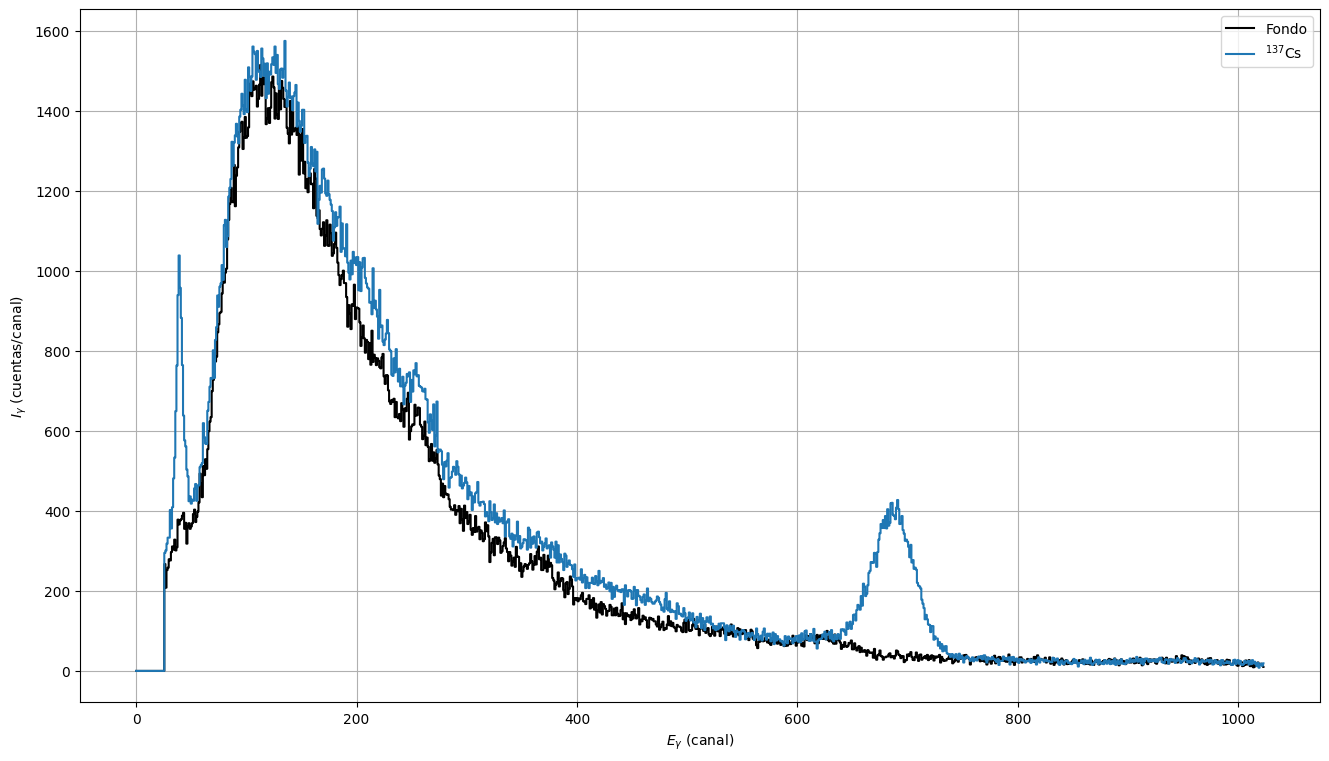

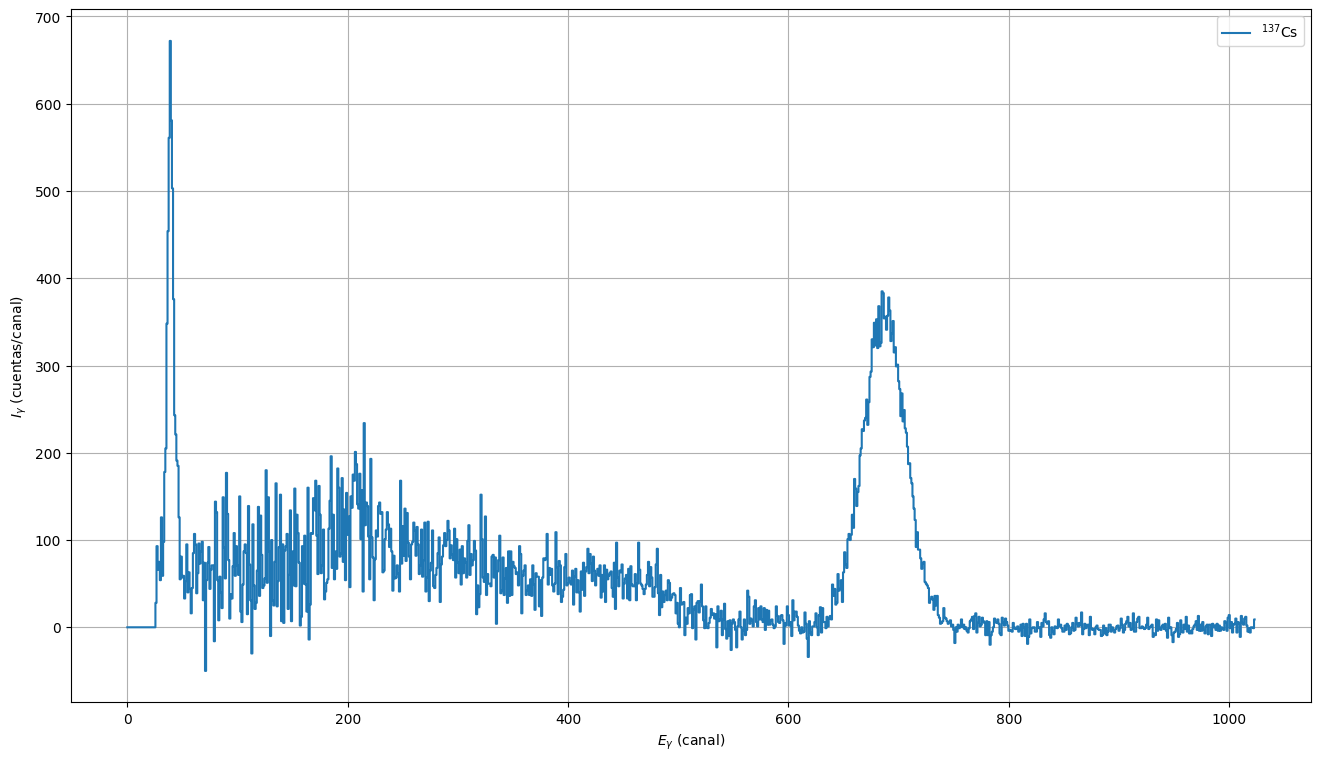


🧾 Procesando 2 picos...

--- Pico #1 ---
Usando rango: Canal mínimo = 10, Canal máximo = 70
Método seleccionado: 2


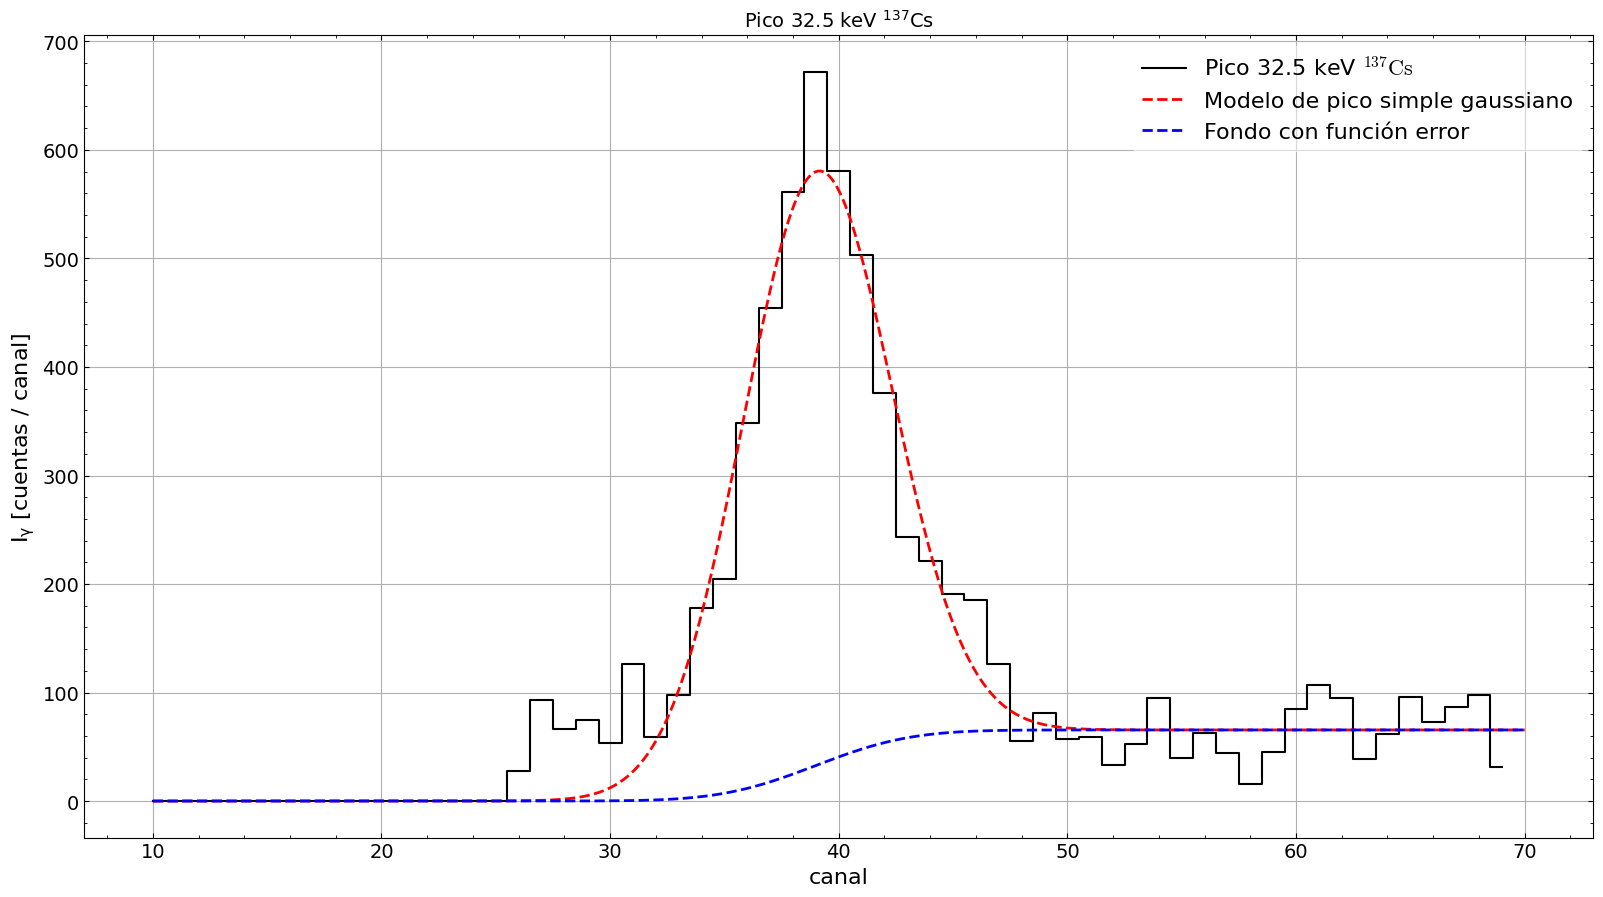

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 60
    # variables        = 5
    chi-square         = 89.9617602
    reduced chi-square = 1.63566837
    Akaike info crit   = 34.3024079
    Bayesian info crit = 44.7741307
    R-squared          = 0.95202846
     Q  = 0.00204403
     df = 55
[[Variables]]
    b0:     65.5773386 +/- 8.40389169 (12.82%) (init = 1)
    b1:    -65.5040015 +/- 8.41439502 (12.85%) (init = 1)
    M:      547.163929 +/- 23.1014774 (4.22%) (init = 672)
    mean:   39.0010451 +/- 0.14806364 (0.38%) (init = 39)
    stdev:  3.25637668 +/- 0.14060660 (4.32%) (init = 9.833333)
    Tau:    26.16983798+/-5.15788192
    Kappa:  1468.32116968+/-253.64634481
    FWHM:    7.66818108+/-0.33110325
    Intensidad:  8852.64006520+/-598.51043331
    Integral:  4466.23971699+/-269.71706175
```

Realizando segundo ajuste con rango: Canal mínimo = 26, Canal máximo = 51


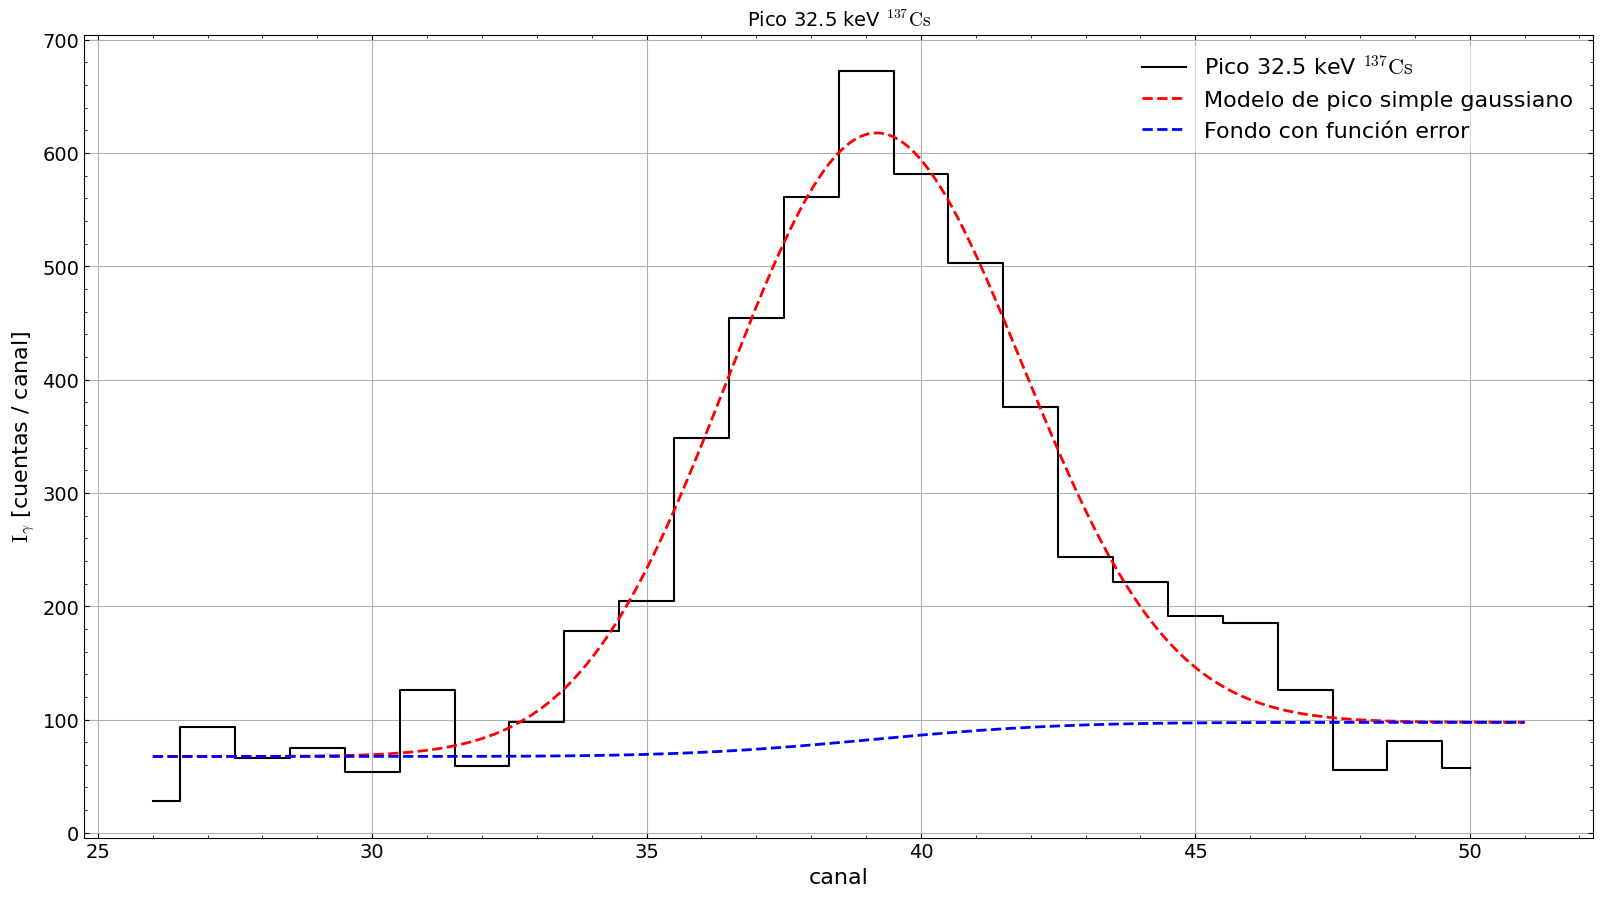

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 25
    # variables        = 5
    chi-square         = 29.5954872
    reduced chi-square = 1.47977436
    Akaike info crit   = 14.2186516
    Bayesian info crit = 20.3130308
    R-squared          = 0.97256118
     Q  = 0.07667874
     df = 20
[[Variables]]
    b0:     97.4641185 +/- 16.0231879 (16.44%) (init = 1)
    b1:    -30.0998574 +/- 18.8352646 (62.58%) (init = 1)
    M:      535.072856 +/- 25.1951419 (4.71%) (init = 672)
    mean:   39.1297112 +/- 0.15233165 (0.39%) (init = 39)
    stdev:  2.68388335 +/- 0.14631701 (5.45%) (init = 4)
    Tau:    -5.12276068+/-1.50106142
    Kappa:  97.26181120+/-21.24151418
    FWHM:    6.32006231+/-0.34455022
    Intensidad:  5060.08920971+/-539.99878955
    Integral:  3599.70150888+/-259.31115220
```


--- Pico #2 ---
Usando rango: Canal mínimo = 550, Canal máximo = 800
Método seleccionado: 1


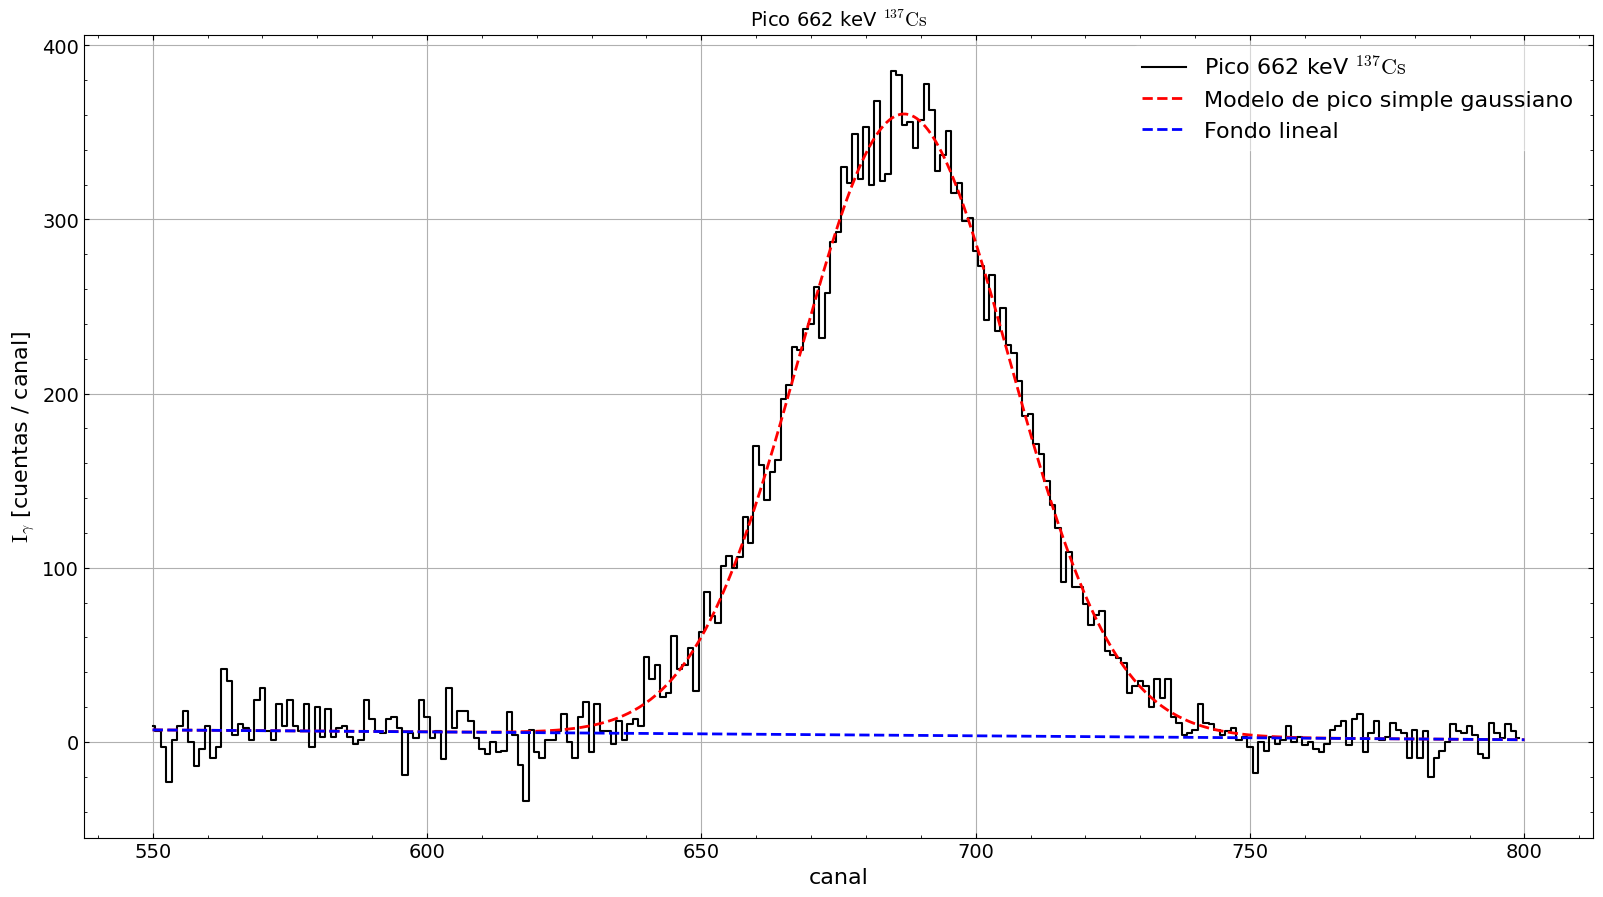

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 250
    # variables        = 5
    chi-square         = 219.162863
    reduced chi-square = 0.89454230
    Akaike info crit   = -22.9114497
    Bayesian info crit = -5.30414509
    R-squared          = 0.98869814
     Q  = 0.88111162
     df = 245
[[Variables]]
    b0:     3.77433717 +/- 0.78598475 (20.82%) (init = 1)
    b1:     0.02262800 +/- 0.00860477 (38.03%) (init = 1)
    M:      356.743648 +/- 3.82514643 (1.07%) (init = 385)
    mean:   686.960540 +/- 0.19908879 (0.03%) (init = 685)
    stdev:  19.1767626 +/- 0.19157289 (1.00%) (init = 41.5)
    Tau:    -26.84877594+/-0.92437423
    Kappa:  397.28915198+/-15.91453228
    FWHM:    45.15782501+/-0.45111967
    Intensidad:  6436.77276806+/-2464.55550904
    Integral:  17148.31589558+/-251.30724738
```

Realizando segundo ajuste con rango: Canal mínimo = 616, Canal máximo = 757


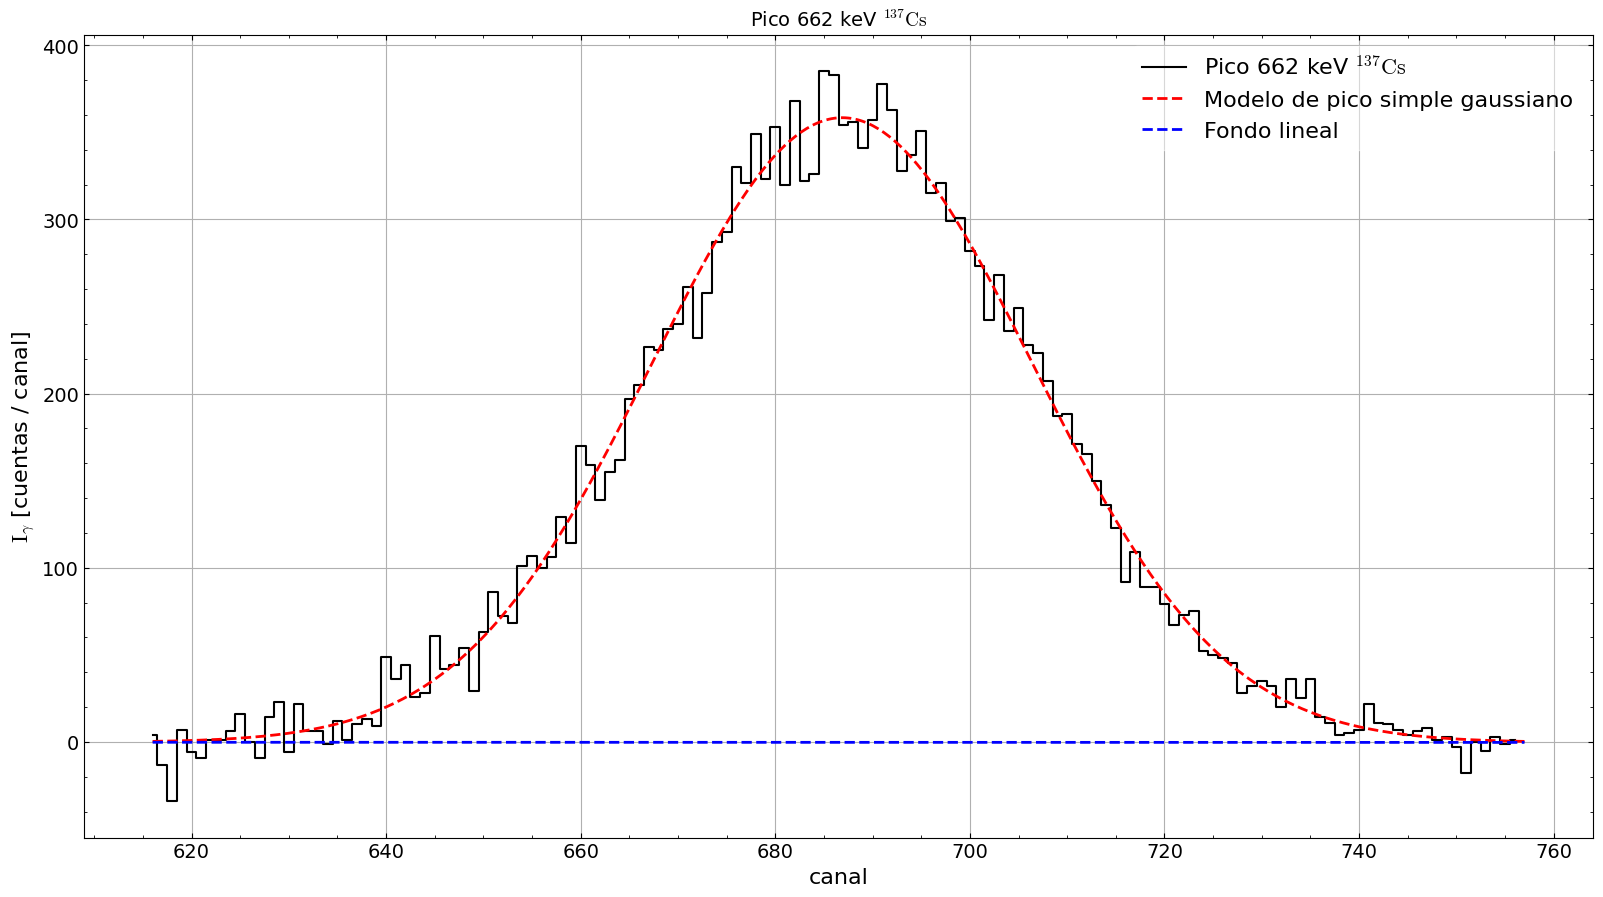

```text
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 141
    # variables        = 5
    chi-square         = 108.476124
    reduced chi-square = 0.79761856
    Akaike info crit   = -26.9744014
    Bayesian info crit = -12.2306020
    R-squared          = 0.99000305
     Q  = 0.96043905
     df = 136
[[Variables]]
    b0:    -0.26627279 +/- 1.60490867 (602.73%) (init = 1)
    b1:     5.4593e-04 +/- 0.02292205 (4198.70%) (init = 1)
    M:      358.632583 +/- 3.63970145 (1.01%) (init = 385)
    mean:   686.878557 +/- 0.20632396 (0.03%) (init = 685)
    stdev:  19.5544102 +/- 0.22435539 (1.15%) (init = 23.33333)
    Tau:    -0.25265357+/-0.13798521
    Kappa:  34.07252582+/-1.56374601
    FWHM:    46.04711702+/-0.52831658
    Intensidad:  17622.90798827+/-265.21333251
    Integral:  17578.60467539+/-269.26697026
```

In [9]:
# Definir los rangos de los picos
configuracion_picos = [
        {"min_range": 10, "max_range": 70, "method": 2, "title": r'Pico 32.5 keV $^{137}Cs$'},
        {"min_range": 550, "max_range": 800, "method": 1, "title": r'Pico 662 keV $^{137}Cs$'},
    ]

# Llamar a la función con la configuración especificada
resultados = peak_fit(
    raw_data_path="Informe2/Data/NaI-SiPM-137Cs-ST-0.050us-0.787us-1200s.mca",
    background_path="Informe2/Data/NaI-SiPM-Fondo-ST-0.050us-0.787us-1200s.mca",
    peak_configs=configuracion_picos,
    width=3.7,
    save_path="Imagenes/lmFit",
    unidades="canal"
)


🧾 Procesando 2 picos...

--- Pico #1 ---


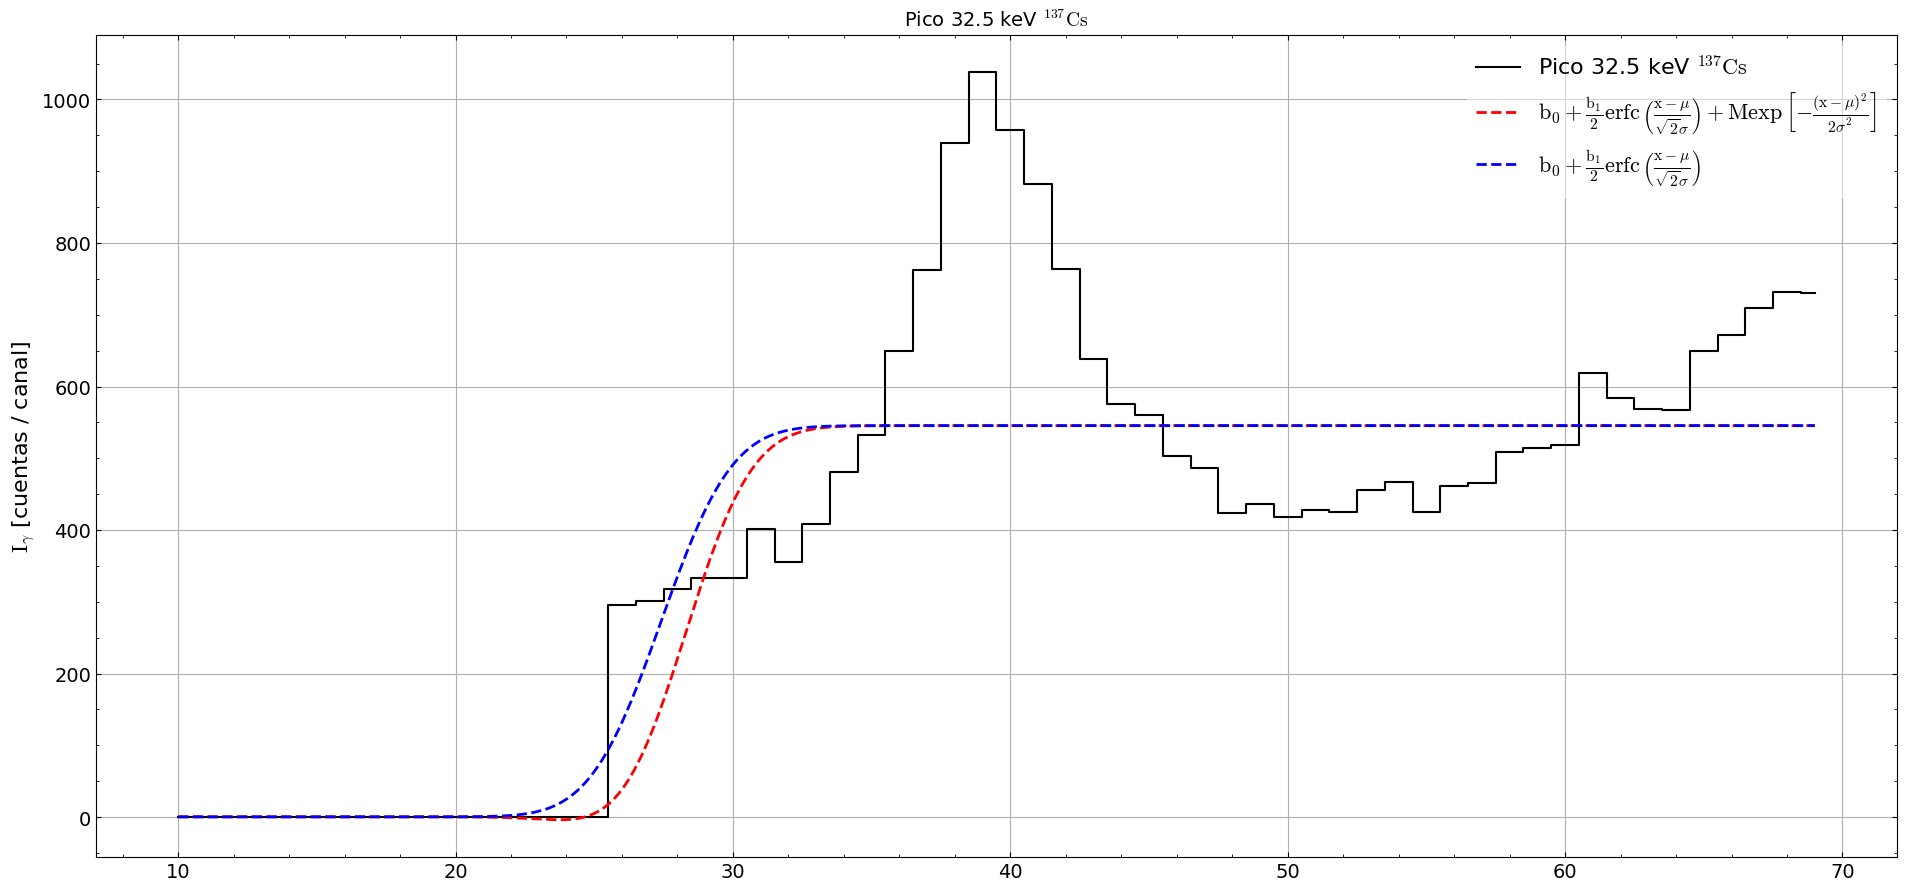


Pico:  Pico 32.5 keV $^{137}Cs$
b0: 545+/-23
b1: -545+/-23
M: -119+/-26
μ: 27.4+/-0.5
σ: 2.0+/-0.4
FWHM: 4.8+/-0.9
Intensidad: (6.0+/-1.7)e+02
Intefral: (1.3+/-1.5)e+03
nu: 55
Chi2: 1938.4351387076101
Reduced Chi2: 35.244275249229275
Q: 0.0
Skewness: 0.7950552606267363
Kurtosis: 3.1812917141435832


<IPython.core.display.Markdown object>

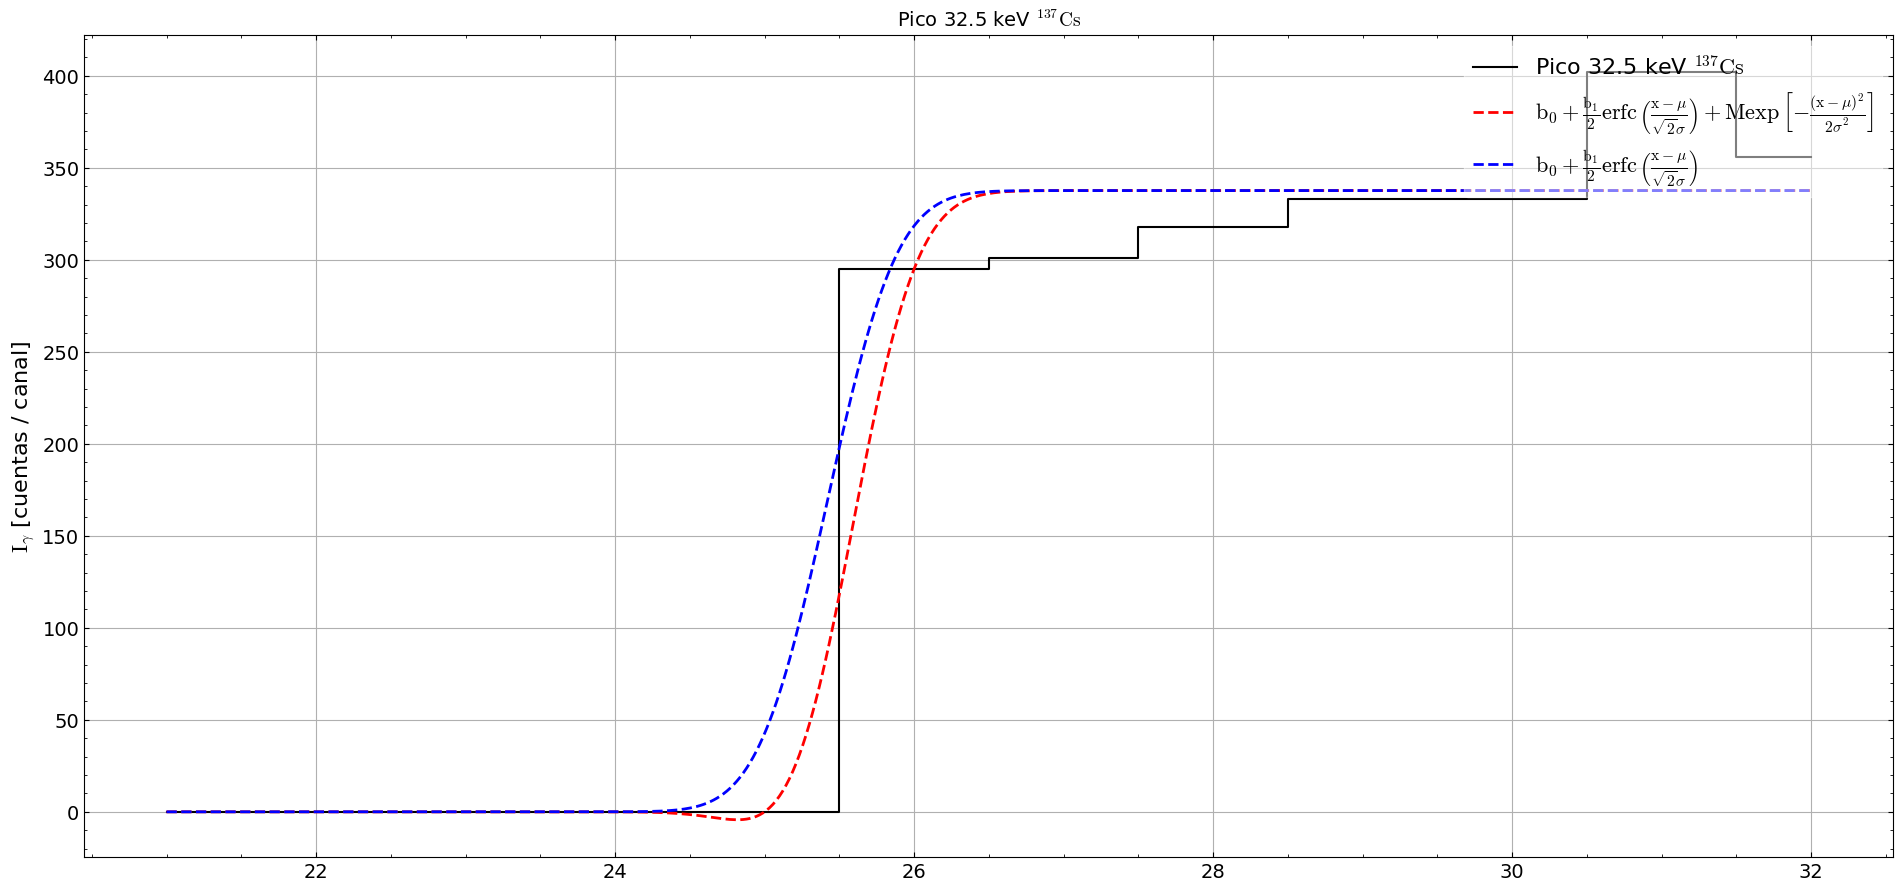


Pico:  Pico 32.5 keV $^{137}Cs$
b0: 338+/-12
b1: -338+/-12
M: (-0.8+/-3.5)e+02
μ: 25.4+/-2.0
σ: 0.4+/-1.0
FWHM: 0.9+/-2.3
Intensidad: (1+/-4)e+02
Intefral: (-0+/-6)e+02
nu: 7
Chi2: 17.05129403562069
Reduced Chi2: 2.4358991479458125
Q: 0.017068405935141584
Skewness: 1.0449706439316993
Kurtosis: 5.167145801989124


<IPython.core.display.Markdown object>


--- Pico #2 ---


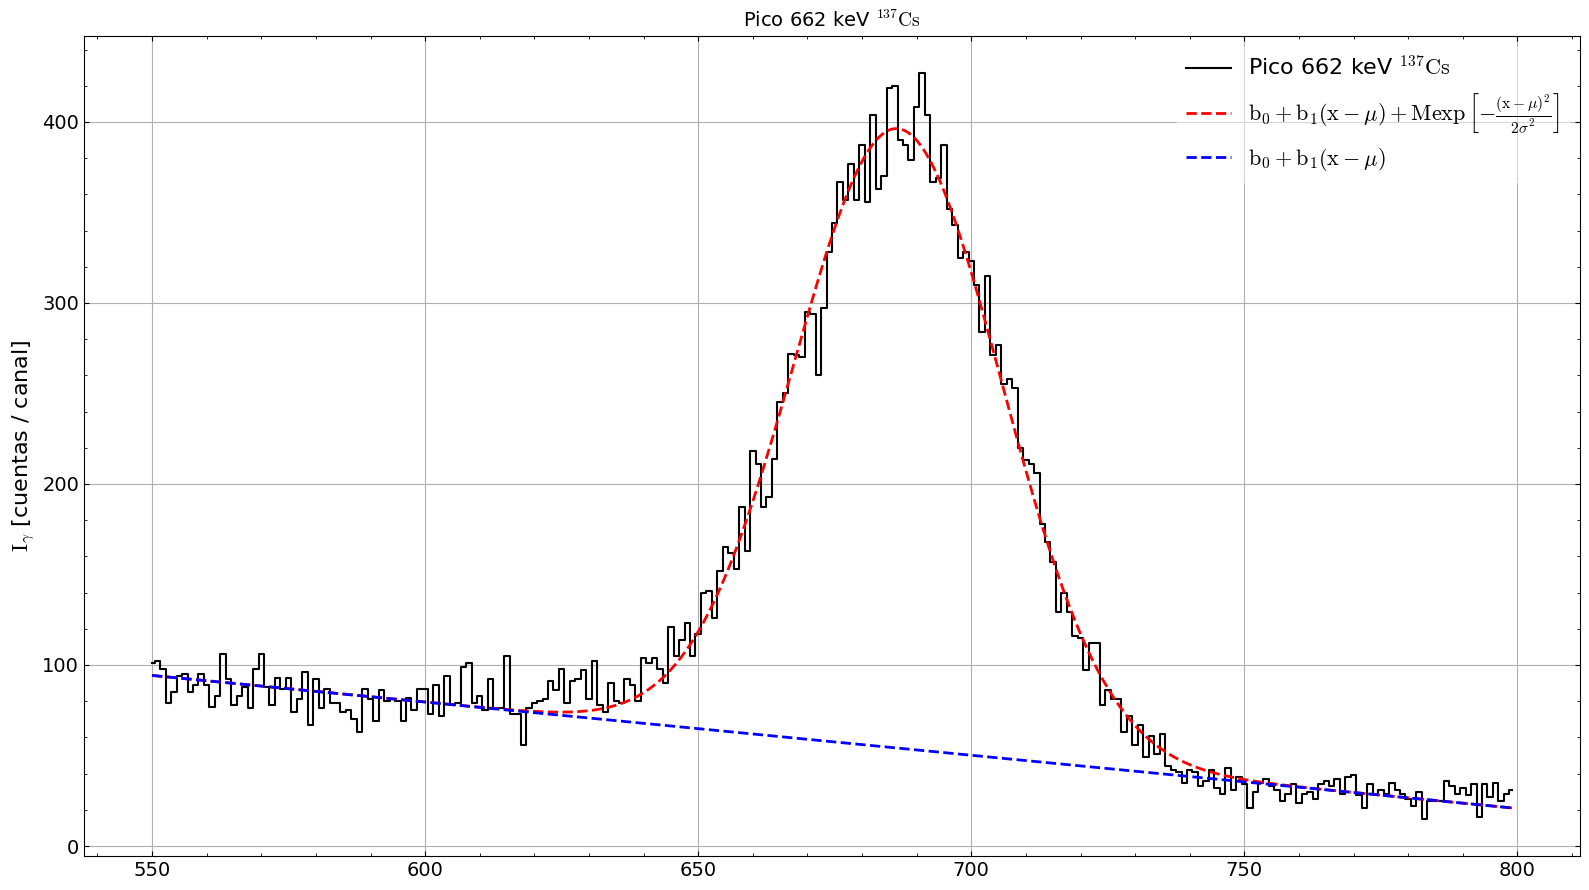


Pico:  Pico 662 keV $^{137}Cs$
b0: 54.1+/-0.7
b1: 0.294+/-0.007
M: 342+/-4
μ: 686.59+/-0.22
σ: 19.00+/-0.20
FWHM: 44.7+/-0.5
Intensidad: (1.661+/-0.025)e+04
Intefral: (1.630+/-0.027)e+04
nu: 245
Chi2: 315.9590786482605
Reduced Chi2: 1.2896288924418797
Q: 0.0014927789821426174
Skewness: -0.2055917323971352
Kurtosis: 2.9503985998248523


<IPython.core.display.Markdown object>

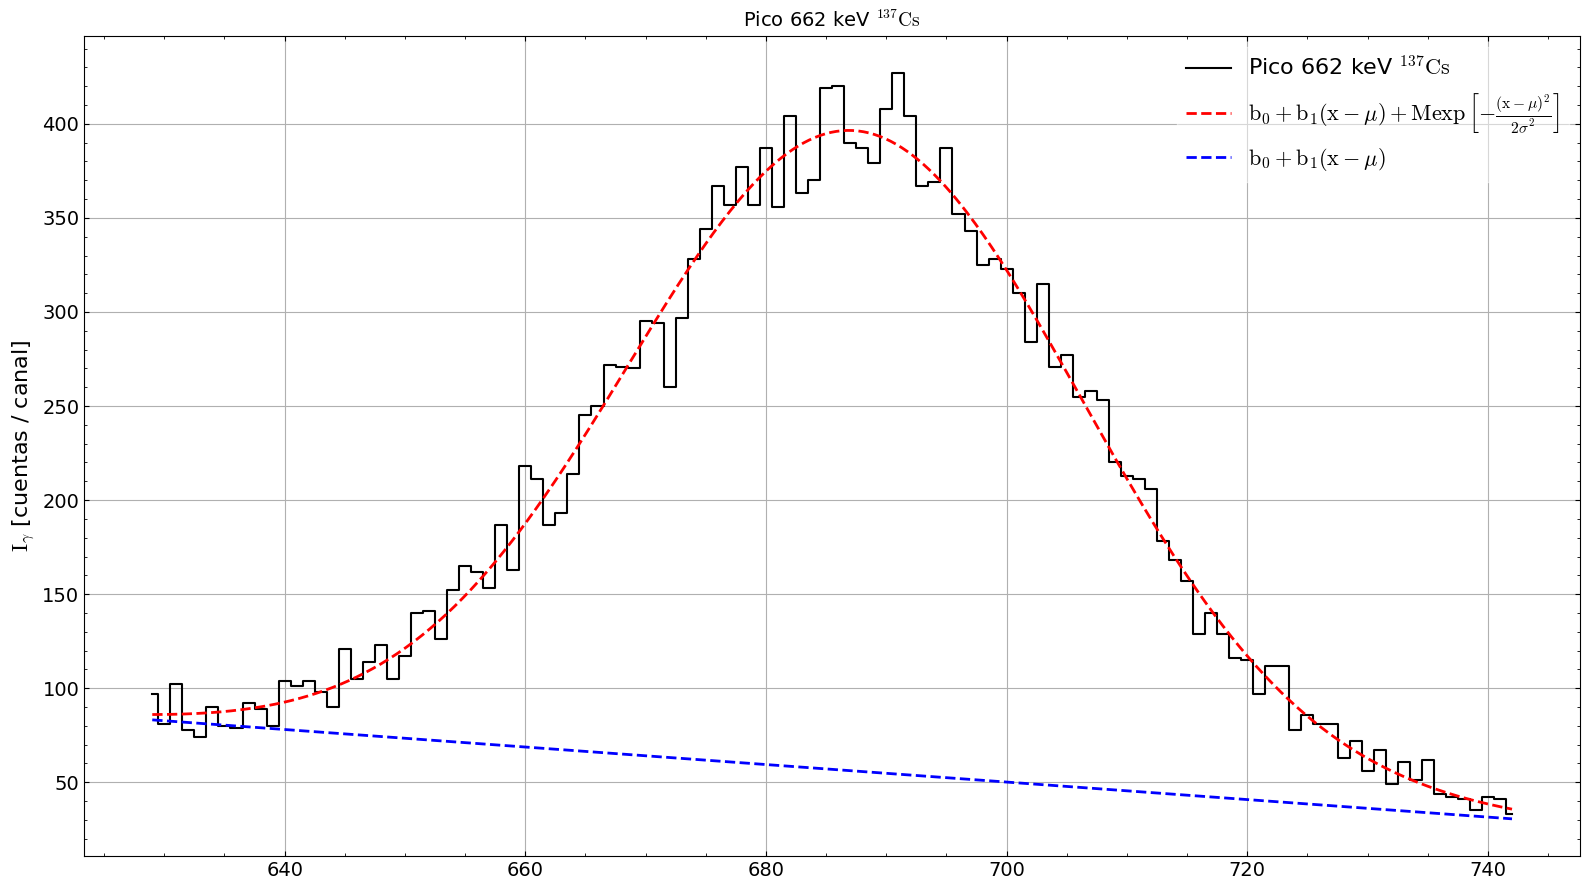


Pico:  Pico 662 keV $^{137}Cs$
b0: 56.0+/-2.1
b1: 0.466+/-0.030
M: 340+/-4
μ: 687.37+/-0.23
σ: 18.87+/-0.26
FWHM: 44.4+/-0.6
Intensidad: (1.616+/-0.028)e+04
Intefral: (1.610+/-0.029)e+04
nu: 109
Chi2: 99.94394254911236
Reduced Chi2: 0.9169169041202969
Q: 0.7209686905550563
Skewness: -0.20769442199280438
Kurtosis: 2.660916020347393


<IPython.core.display.Markdown object>

(array([5.59807737e+01, 4.65602242e-01, 3.40406217e+02, 6.87372209e+02,
        1.88690337e+01]),
 array([[ 4.24939346e+00,  5.35185502e-03, -1.77687909e+00,
          1.47926259e-04, -4.22752638e-01],
        [ 5.35185502e-03,  8.88126299e-04, -8.50437211e-03,
          3.82014298e-03, -2.00420527e-04],
        [-1.77687909e+00, -8.50437211e-03,  1.41904741e+01,
         -1.70168307e-02, -1.83409046e-01],
        [ 1.47926259e-04,  3.82014298e-03, -1.70168307e-02,
          5.13295018e-02, -3.18930043e-03],
        [-4.22752638e-01, -2.00420527e-04, -1.83409046e-01,
         -3.18930043e-03,  6.88250609e-02]]),
 array([5.40709856e+01, 2.93962781e-01, 3.42200097e+02, 6.86588104e+02,
        1.89992201e+01]),
 array([[ 4.65563366e-01,  1.28955738e-03, -1.41273173e-01,
         -1.03756597e-02, -5.02070646e-02],
        [ 1.28955738e-03,  5.53856158e-05, -9.80486538e-04,
          2.54125028e-04, -9.63481401e-05],
        [-1.41273173e-01, -9.80486538e-04,  1.86980845e+01,
          2.65

In [10]:
  configuracion_picos = [
        {"min_range": 10, "max_range": 70, "method": 2, "title": r'Pico 32.5 keV $^{137}Cs$'},
        {"min_range": 550, "max_range": 800, "method": 1, "title": r'Pico 662 keV $^{137}Cs$'},
    ]
    
    # Calibración para convertir canales a energía (si se conoce)
    # calibracion = (a_0, a_1)  # Donde E = a_0 + a_1 * canal
    
    # Llamar a la función principal
analizar_espectro(
        "Informe2/Data/NaI-SiPM-137Cs-ST-0.050us-0.787us-1200s.mca",
        "Informe2/Data/NaI-SiPM-Fondo-ST-0.050us-0.787us-1200s.mca",  # Opcional
        configuracion_picos=configuracion_picos,
        calibracion=None,  # Opcional
        save_path="Imagenes",  # Opcional
        ylim=None
    )

# Energy and FWHM


Ajuste lineal (Canal vs. Energía en keV):
a0:        -42.75 ± 0.02
a1:        3.1083 ± 0.0001


NameError: name 'save_path' is not defined

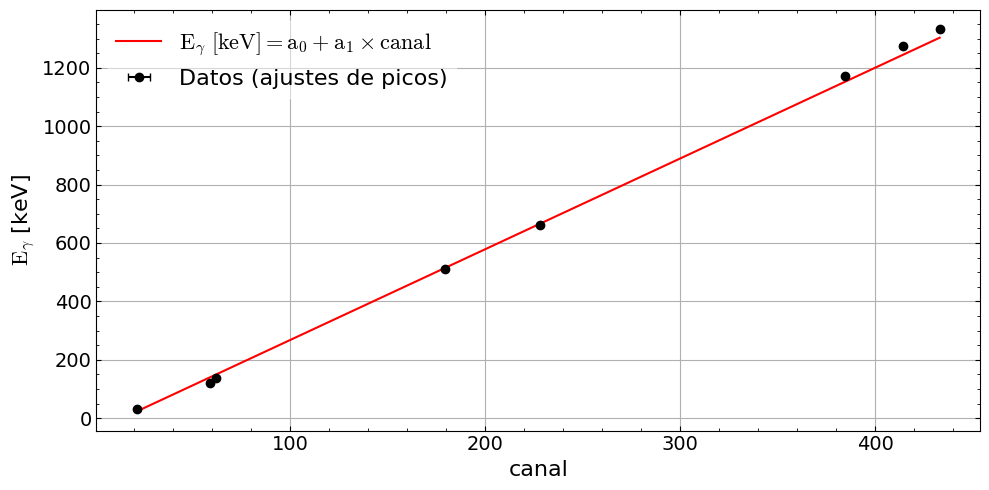

In [11]:

#%% Ajuste Canal vs. Energía (calibración)
E_gamma_keV = np.array([32.8, 122.1, 136.5, 511.0, 661.7, 1173.2, 1274.5, 1332.5])
E_gamma_canal = np.array([21.14, 58.56, 61.83, 179.47, 228.09, 384.68, 414.17, 432.98])
dE_gamma_canal = np.array([0.02, 0.03, 0.10, 0.05, 0.02, 0.07, 0.18, 0.09])
fwhm_canal = [2.88, 6.80, 7.35, 13.60, 16.09, 20.81, 23.37, 22.23]
dfwhm_canal = np.array([0.06, 0.11, 0.08, 0.15, 0.05, 0.19, 0.49, 0.24])

def linear(x, a, b):
    return a + b*x

popt, pcov = curve_fit(linear, E_gamma_canal, E_gamma_keV,
                       sigma=dE_gamma_canal, absolute_sigma=True)
a, b = popt
uncertainties = np.sqrt(np.diag(pcov))

x_fit = np.linspace(min(E_gamma_canal), max(E_gamma_canal), 100)
y_fit = linear(x_fit, *popt)

print("\nAjuste lineal (Canal vs. Energía en keV):")
print("a0:        {:.2f} ± {:.2f}".format(a, uncertainties[0]))
print("a1:        {:.4f} ± {:.4f}".format(b, uncertainties[1]))

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(E_gamma_canal, E_gamma_keV, xerr=dE_gamma_canal,
            fmt='o', label="Datos (ajustes de picos)", color='k', capsize=3)
ax.plot(x_fit, y_fit, '-r', label=r"$E_{\gamma} \ [keV] = a_0 + a_1 \times canal$")
ax.set_ylabel(r'$E_{\gamma}$ [keV]')
ax.set_xlabel('canal')
ax.grid()

formato_grafico(legend_loc='upper left')
plt.tight_layout()

filename = "Practica2_Calibracion.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()

E_gamma_ajuste = linear(E_gamma_canal, *popt)
delta = E_gamma_keV - E_gamma_ajuste
percent_error = (delta / E_gamma_keV) * 100

dE_gamma_ajuste = np.sqrt((uncertainties[0])**2 + (uncertainties[1]*E_gamma_canal)**2)
d_delta = dE_gamma_ajuste
d_percent_error = (d_delta / E_gamma_keV) * 100

# Convertir FWHM de canales a keV
fwhm_canal = np.array(fwhm_canal)
fwhm_kev = linear(E_gamma_canal + fwhm_canal, a, b) - linear(E_gamma_canal, a, b)
# Ajuste rápido para la incertidumbre en FWHM
dfwhm_kev = np.sqrt((uncertainties[1]*fwhm_canal) ** 2 + (b * dfwhm_canal) ** 2)

print("\nTabla con los resultados:")
print("------------------------------------------------------------------------------------------")
print("| Eγ (keV)   | Canal     | Eγ ajuste (keV) ± Δ | Δ (keV) ± Δ | % Δ/Eγ ± % | FWHM (keV) ± Δ |")
print("------------------------------------------------------------------------------------------")
for energia, canal, err_canal, ajuste, d, perc, d_aj, d_del, d_perc, fwhm_k, dfwhm_k in zip(
        E_gamma_keV, E_gamma_canal, dE_gamma_canal, E_gamma_ajuste, delta, percent_error,
        dE_gamma_ajuste, d_delta, d_percent_error, fwhm_kev, dfwhm_kev):
    print("| {:10.1f} | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) | {:10.2f}({:.2f}) |".format(
        energia, canal, err_canal, ajuste, d_aj, d, d_del, perc, d_perc, fwhm_k, dfwhm_k))
print("------------------------------------------------------------------------------------------")

# Ajuste FWHM = c0 + c1 * sqrt(Eγ)
def fwhm_model(E_gamma, c0, c1):
    return c0 + c1*np.sqrt(E_gamma)

popt_fwhm, pcov_fwhm = curve_fit(fwhm_model, E_gamma_keV, fwhm_kev,
                                 sigma=dfwhm_kev, absolute_sigma=True)
c0, c1 = popt_fwhm
uncertainties_fwhm = np.sqrt(np.diag(pcov_fwhm))

E_gamma_fit = np.linspace(min(E_gamma_keV), max(E_gamma_keV), 100)
fwhm_fit = fwhm_model(E_gamma_fit, *popt_fwhm)

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(np.sqrt(E_gamma_keV), fwhm_kev, yerr=dfwhm_kev,
            fmt='o', label="Datos experimentales", color='k', capsize=3)
ax.plot(np.sqrt(E_gamma_fit), fwhm_fit, '-r',
        label=r"$\text{FWHM} = c_0 + c_1 \sqrt{E_\gamma}$")

ax.set_xlabel(r'$\sqrt{E_{\gamma}}$ [keV$^{1/2}$]')
ax.set_ylabel(r'FWHM [keV]')
ax.grid()
formato_grafico(legend_loc='upper left')
plt.tight_layout()

filename_fwhm = "Practica2_FWHM_Ajuste.png"
full_path_fwhm = os.path.join(save_path, filename_fwhm)
plt.savefig(full_path_fwhm, dpi=300, bbox_inches='tight')
plt.show()

print("\nAjuste de FWHM en función de √Eγ:")
print("c0: {:.3f} ± {:.3f}".format(c0, uncertainties_fwhm[0]))
print("c1: {:.3f} ± {:.3f}".format(c1, uncertainties_fwhm[1]))

# Coef. de correlación
sqrt_E_gamma = np.sqrt(E_gamma_keV)
c1_, c0_ = np.polyfit(sqrt_E_gamma, fwhm_kev, 1)
fwhm_ajuste = c0_ + c1_ * sqrt_E_gamma
r_value = np.corrcoef(fwhm_kev, fwhm_ajuste)[0,1]
print(f"Coeficiente de correlación R: {r_value:.4f}")

#%% Actividad
E_gamma_keV = np.array([32.8, 122.1, 136.5, 661.7, 1173.2, 1274.5, 1332.5])
T_1div2 = np.array([11205.5, 271.79, 271.79, 11205.5, 1924.1, 926.3, 1924.1])
tau = T_1div2 / np.log(2)
t_0 = [18052006,5032018,5032018,18052006,8062006,6072006,8062006]
A_0 = np.array([35.1,40.7,40.7,35.1,34.8,31.9,34.8])

t = 5032018
b_gamma = np.array([80.7696,85.60,10.68,85.1,99.857,99.935,99.983])
d_b_gamma = np.array([0,0.17,0.08,0.2,0.022,0.015,0.006])
I = np.array([30262,32418,4176,182714,28315,5264,26255])
d_I = np.array([5468,1335,402,715,334,138,358])
dt = [2,1,1,2,2,2,2]

fechas_0 = [datetime.strptime(str(fecha), "%d%m%Y").date() for fecha in t_0]
fecha_t = datetime.strptime(str(t), "%d%m%Y").date()
d_t = np.array([abs((fecha_t - f).days) for f in fechas_0])

A = A_0*np.exp(-d_t/tau)
A_gamma = A * b_gamma/100
d_A_gamma = A_gamma*np.sqrt((d_b_gamma/b_gamma)**2)

epsilon = I/(A_gamma*dt)
d_epsilon = epsilon*np.sqrt((d_I/I)**2 + (d_A_gamma/A_gamma)**2)

print(f"{'E_gamma (keV)':>12} | {'A (kBq)':>15} | {'b_gamma':>10} | {'A_gamma (kBq)':>15} | {'I':>10} | {'ε':>15}")
print("-"*120)
for i in range(len(E_gamma_keV)):
    print(f"{E_gamma_keV[i]:>12.1f} | "
          f"{A[i]:>10.2f} | "
          f"{b_gamma[i]:.2f}({d_b_gamma[i]:.3f}) | "
          f"{A_gamma[i]:>15.2f}({d_A_gamma[i]:.2f}) | "
          f"{I[i]:>10}({d_I[i]:.0f}) | "
          f"{epsilon[i]:>10.5f}({d_epsilon[i]:.3f})")

epsilon_norm = epsilon / np.max(epsilon)
d_epsilon_norm = d_epsilon / np.max(epsilon)

plt.figure(figsize=(10, 5))
plt.errorbar(E_gamma_keV, epsilon_norm, yerr=d_epsilon_norm, c='k', fmt='o', capsize=5)
plt.xlabel('Energía (keV)')
plt.ylabel('Eficiencia Normalizada')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
formato_grafico(decimaly=1)

filename = "Practica2_Eficiencia.png"
full_path = os.path.join(save_path, filename)
plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()